<center><font color='green'> Project Name: VA Predictive Model - Fifth Model</font></center>
<br><font color='green'> Note:</font></br>
<br><font color='green'>
1.	Pull VBE Nonveterans
2.	Pull Non-Veteran not from VBE with tenure than 6 months
3.	Pull the ids for all members who are going be trained for the model
4.	Pull of demographic information
5.  Pull Medical Utilization data
6.  Add PCP indicator
7.  Add HEDIS Variables
8.  Priorization
9.  Pull claims of members who are both sampled veterans and Nonveterans
10. Create dataset for the predictors, look at CPT Code
11. Pull HPD Health Variables
12. Pull Disability Data
13. Pull Rx Data
14. Pull Member Interaction Data
15. Create dataset for the predictors, look at Geographic Data
16. Revised Model
</font></br>
<font color='green'><p>*By David Geng*</p></font>
<font color='green'><p>*Manager: Ting Withers*</p></font>
<font color='green'><p>*Created on: 08/22/2020*</p></font>
<font color='green'><p>*Last Modified: 09/09/2020*</p></font>

In [1]:
# import all packages
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# set display options
pd.set_option('display.max_rows',20)
pd.set_option('display.max_columns',80)
pd.set_option('display.width',100)
pd.set_option('display.precision',7)

In [3]:
# set username and password for access databases
USERNAME = 'a427813'
PASSWORD= 'Satellite1#'

In [4]:
def decile(estimator,X,Y):
    full_file_x = X.copy()
    full_file_y = Y.copy()
    full_file_x['Prob'] = estimator.predict_proba(full_file_x)[:,1]
    full_file_x['Deciles']= pd.qcut(full_file_x.Prob.rank(method='first'),q=10,labels=np.arange(10,0,-1),)
    full_file_x['Target'] = full_file_y.values
    k = full_file_x.groupby(['Deciles','Target']).size().unstack().fillna(0).rename(columns= {0:'Zero',1:'Ones'})
    k['Population'] = k['Ones']+k['Zero']
    summary=k.sort_index(ascending=False)
    summary['TargetRate']=summary['Ones']/summary['Population']
    summary['CumulativeTargetRate']=summary['Ones'].cumsum()/summary['Population'].cumsum()
    summary['TargetsCaptured']=summary['Ones'].cumsum()/summary['Ones'].sum()
    return summary

<font color='green'>**-----------------------------------------------Part 1-4:  Pull All MAPD Members and the demographic info. -----------------------------------**</font>

In [5]:
# pull demographics from sales table for the vaterans
import pyodbc
conn=pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                    'Server=MEPRPRDDB;'
                    'Database=MEPRBI;'
                    'Trusted_Connection=yes;')

In [6]:
# pull demographics from sales table
import pyodbc
conn=pyodbc.connect('Driver={SQL Server Native Client 11.0};'
                    'Server=MEPRPRDDB;'
                    'Database=MEPRBI;'
                    'Trusted_Connection=yes;')
query=f'''select distinct 
MEDICARE_NUMBER, Member_ID, cast(Eff_Date as varchar(10)) as Eff_Date, cast (Term_Date as varchar(10)) as Term_Date, 
Mbr_Mths, Contract_Number,PBP,Product, CMS_County, CMS_State, NEW_REGION, MA_Territory, DOB, Age, Gender, 
left(Zip,5) as Zip, FIPS, Plan_Type, dual_Status, PCP_Name, PCP_Tax_ID, GroupName, GroupNumber, GroupSegment, 
GroupSegmentName, TRR_Parent_Name, TOH_Name, Recruiter_Name, Writing_Agent_Name, Sales_Channel, New_Market, SNP, LIS_Flag,
Enroll_Status,Issued_Status,Group_Status
  from tbl_0125_MEPR_Run_prd 
  where PRODUCT='MA' 
        and ISSUED_STATUS = 'Issued'  
        and Group_Status='Individual'
        and (Eff_Date <= cast('2020-07-01' as datetime)) and (Term_Date >= cast('2020-07-31' as datetime));
'''
MAPD_IDVL_DF = pd.read_sql_query(query, conn)
print(MAPD_IDVL_DF.shape)
MAPD_IDVL_DF.head()

(1601916, 36)


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status
0,None,161052569013,2020-01-01,9999-12-31,8,H1610,001,MA,ROANOKE,VA,MIDATLANTIC,VA_ROANOKE,1937-09-27,82,F,24179,51161,HMO,None,"YOUNGBLOOD, ELLA M",None,None,None,None,None,None,CareFree,CareFree,"Peterson, Jasmine",HealthSpire,CAPITOL,Y,1,Active,Issued,Individual
1,None,990013386013,2020-04-01,9999-12-31,5,H1610,001,MA,CHESAPEAKE CITY,VA,MIDATLANTIC,VA_NEWPORT_NEWS,1957-11-22,62,M,23320,51550,HMO,None,"ABOLHASSANI, MOHAMMAD R",None,None,None,None,None,None,CareFree,"Carefree Direct Agency, LLC","SANDERS, TIWANNA",CareFree,CAPITOL,Y,1,Active,Issued,Individual
2,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual
3,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual
4,1A00CR2PG14,101184248500,2020-07-01,9999-12-31,2,H3288,014,MA,HARRIS,TX,SOUTHCENTRAL,TX_HOUSTON,1955-06-06,65,F,77072,48201,PPO,None,Memorial Hermann ACO ...,169063720,None,None,None,None,None,"Amerilife Agencies,","LOPEZ, ROUMALDA","Kelly, Kim",NDP,SOUTHCENTRAL,None,None,Active,Issued,Individual


In [8]:
# Only keep member with current actives
Active_members=MAPD_IDVL_DF[MAPD_IDVL_DF['Enroll_Status']=='Active']
Active_members=Active_members.sort_values(by=['MEDICARE_NUMBER','Member_ID','Eff_Date'])
print('Check uniqueness of the data: ',Active_members.MEDICARE_NUMBER.nunique())
print(Active_members.shape)
Active_members.head()

Check uniqueness of the data:  1577194
(1577220, 36)


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status
2,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual
243,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual
244,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual
245,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual
3,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual


<font color='green'>**-------------------------------------------Part 5:  Pull Medical Utilization data. -------------------------------**</font>

In [9]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [10]:
  # pull medical utilization data which needs to split data into chunks
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_1 =  """ 
select m360.SRC_MEMBER_ID,
count (distinct case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cl.src_clm_id else null end) as emerg_transactions, 
count (distinct case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cl.src_clm_id else null end) as pcp_transactions, 
count (distinct case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cl.src_clm_id else null end) as spclst_transactions, 
count (distinct case when cl.PLC_SRV_CTG_CD = 'I'  or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cl.src_clm_id else null end) as IP_transactions,
 
count (distinct case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as emerg_visits, 
count (distinct case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as primary_care_visits,
count (distinct case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as spclst_visits,
count (distinct case when cl.PLC_SRV_CTG_CD = 'I' or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as IP_visits,
count (distinct case when (cl.PRCDR_CD in ('G0402','G0403','G0404','G0405','G0438','G0439') or 
(PRCDR_CD  IN ('99381','99382','99383','99384','99385','99386','99387','99388','99389','99390',
    '99391','99392','99393','99394','99395','99396','99397','99401','99402','99403','99404',
    '99201','99202','99203','99204','99205','99211','99212','99213','99214','99215')
and pri_icd9_dx_cd IN ('V03.0','V03.1','V03.2','V03.3','V03.4','V03.5','V03.6','V03.7','V03.8',
    'V03.9','V04.0','V04.1','V04.2','V04.3','V04.4','V04.5','V04.6',
    'V04.7','V04.8','V04.9','V04.10','V04.11','V04.12','V04.13','V04.14','V04.15','V04.16','V04.17','V04.18',
    'V04.19','V04.20','V04.21','V04.22','V04.23','V04.24','V04.25','V04.26','V04.27','V04.28','V04.29','V04.30',
    'V04.31','V04.32','V04.33','V04.34','V04.35','V04.36','V04.37','V04.38','V04.39','V04.40','V04.41','V04.42',
    'V04.43','V04.44','V04.45','V04.46','V04.47','V04.48','V04.49','V04.50','V04.51','V04.52','V04.53','V04.54',
    'V04.55','V04.56','V04.57','V04.58','V04.59','V04.60','V04.61','V04.62','V04.63','V04.64','V04.65','V04.66',
    'V04.67','V04.68','V04.69','V04.70','V04.71','V04.72','V04.73','V04.74','V04.75','V04.76','V04.77','V04.78',
    'V04.79','V04.80','V04.81','V04.82','V04.83','V04.84','V04.85','V04.86','V04.87','V04.88','V04.89',
    'V05.0','V05.1','V05.2','V05.3','V05.4','V05.5','V05.6','V05.7','V05.8','V05.9',
    'V06.0','V06.1','V06.2','V06.3','V06.4','V06.5','V06.6','V06.7','V06.8','V06.9','V20.0','V20.1','V20.2',
    'V70.0','V70.3','V70.5','Z23','Z76.1','Z76.2')))
then cast(cl.member_id as varchar(25)) || 
cast(cl.SRV_START_DT as varchar(10)) else null end) as preventive_care_visits
 
,sum (case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cl.paid_amt else 0 end) as emerg_benefit_paid_amt 
,sum (case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cl.paid_amt else 0 end) as pcp_benefit_paid_amt
,sum (case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cl.paid_amt else 0 end) as spclst_benefit_paid_amt
,sum (case when cl.PLC_SRV_CTG_CD = 'I' or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cl.paid_amt else 0 end) as IP_benefit_paid_amt
 
,sum (case when cl.hcfa_plc_srv_cd = '23' or cl.prcdr_cd in ('99281', '99282', '99283', '99284', '99285', '99288', 'G0380', 'G0381', 'G0382', 'G0383', 'G0384') then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as emerg_mbr_paid_amt 
,sum (case when (cl.src_prvdr_ty_cd in ('PP', 'OB') or cl.srv_spclty_ctg_cd in ('FP','I','P', 'OG')) then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as pcp_mbr_paid_amt
,sum (case when (cl.src_prvdr_ty_cd in ('SP', 'SG') or cl.srv_spclty_ctg_cd in ('A','C','D','E','G','H','II','MG','N','NE','NN','OP','PD','PY','RH', 'CS','DC','EN','NS','O','OR','OS','PS', 'S','U','VS', 'RO', 'VVDT', 'VVMH', 'VVPD', 'VVRH', 'VRAD', 'WBHP', 'WDI', 'WRAD', 'WSD', 'WBHF', 'WSA', 'WOTF')) then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as spclst_mbr_paid_amt
,sum (case when cl.PLC_SRV_CTG_CD = 'I' or cl.prcdr_cd in ('99221', '99222', '99223', '99224', '99225', '99226', '99231', '99232', '99233', '99234', '99235', '99236', '99238', '99239') then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as IP_mbr_paid_amt
 
,count(distinct case when  cl.paid_prvdr_par_cd='Y' then cl.src_clm_id else null end) as Par_Med_claim_count 
,count(distinct case when  cl.paid_prvdr_par_cd='N' then cl.src_clm_id else null end) as NonPar_Med_claim_count
 
,count(distinct case when cl.paid_prvdr_par_cd='Y' then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as Par_Med_visits 
,count(distinct case when cl.paid_prvdr_par_cd='N' then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as NonPar_Med_visits 
 
,sum(case when cl.paid_prvdr_par_cd='Y' then cl.paid_amt else 0 end) as Par_Med_benefit_paid_amt 
,sum(case when cl.paid_prvdr_par_cd='N' then cl.paid_amt else 0 end) as NonPar_Med_benefit_paid_amt 
,sum(case when cl.paid_prvdr_par_cd='Y' then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as Par_Med_mbr_paid_amt
,sum(case when cl.paid_prvdr_par_cd='N' then cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt else 0 end) as NonPar_Med_mbr_paid_amt 
 
,sum(cl.paid_amt) as Aetna_Med_paid_amt
,sum(cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt) as Mbr_Med_paid_amt
,sum(cl.paid_amt) + sum(cl.srv_copay_amt + cl.coinsurance_amt + cl.deductible_amt) as Total_Med_Cost

,sum(cl.deductible_amt) as Mbr_Med_deductible_paid_amt
,sum(case when cl.paid_prvdr_par_cd='Y' then cl.deductible_amt else 0 end) as Par_Med_mbr_deductible_paid_amt 
,sum(case when cl.paid_prvdr_par_cd='N' then cl.deductible_amt else 0 end) as NonPar_Med_mbr_deductible_paid_amt 
 
,count(distinct case when cl.hcfa_plc_srv_cd in ('41', '42') or cl.prcdr_cd in ('A0425', 'A0426', 'A0427', 'A0428', 'A0429', 'A0432', 'A0433', 'A0434') then cl.src_clm_id else null end) as Ambulance_claim_count
,count(distinct case when cl.hcfa_plc_srv_cd in ('41', '42') or cl.prcdr_cd in ('A0425', 'A0426', 'A0427', 'A0428', 'A0429', 'A0432', 'A0433', 'A0434') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as Ambulance_event_count
 
,count(distinct case when cl.SRV_LINE_TYPE_CD='BH' or cl.src_prvdr_ty_cd in ('ABA', 'BAA',  'BHG', 'BHR', 'CP', 'DAC', 'MH', 'MR', 'NPB', 'PAB', 'PE', 'PN', 'PSH', 'SA') or cl.srv_spclty_ctg_cd in ('WBHP', 'WBHF', 'WSA', 'PY', 'VVMH') then cl.src_clm_id else null end) as Behavioral_Health_claim_count /*I manually include provider type code and specialty category code to be more comprehensive.*/
,count(distinct case when cl.SRV_LINE_TYPE_CD='BH' or cl.src_prvdr_ty_cd in ('ABA', 'BAA',  'BHG', 'BHR', 'CP', 'DAC', 'MH', 'MR', 'NPB', 'PAB', 'PE', 'PN', 'PSH', 'SA') or cl.srv_spclty_ctg_cd in ('WBHP', 'WBHF', 'WSA', 'PY', 'VVMH') then cast(cl.member_id as varchar(25)) || cast(cl.SRV_START_DT as varchar(10)) else null end) as Behavioral_Health_visits /*I observed a situation that member had 2 visits on 2 different dates, but both visits were filed under the same source claim id.*/
 
from starstemp.stars_analytics_mbr_360 m360
inner join iwh.claim_line cl on m360.member_id=cl.member_id
where m360.reporting_year=2020
and m360.mdcr_offer_typ_cd in ('MAPD', 'MA')
and cl.srv_start_dt between '01/01/2020' and '06/30/2020'
and cl.business_ln_cd = 'ME'
and cl.summarized_srv_ind='Y'
and cl.clm_ln_status_cd='P'
and m360.src_member_id in {}
group by m360.src_member_id;
    """.format(tuple(newmbr_list))

    exrt1= pd.read_sql(query_1,conn)
    exrt1 = exrt1.drop_duplicates()
    #appending the final extract to a list
    appended_data.append(exrt1)
    #increment the index
    i += 1

# appending all the DF's
appended_data = pd.concat(appended_data, axis=0,ignore_index=True) 
appended_data.drop_duplicates(inplace=True)
print(appended_data.shape)
appended_data.head(1)

Fetching member details from 0,10000
Fetching member details from 10000,20000
Fetching member details from 20000,30000
Fetching member details from 30000,40000
Fetching member details from 40000,50000
Fetching member details from 50000,60000
Fetching member details from 60000,70000
Fetching member details from 70000,80000
Fetching member details from 80000,90000
Fetching member details from 90000,100000
Fetching member details from 100000,110000
Fetching member details from 110000,120000
Fetching member details from 120000,130000
Fetching member details from 130000,140000
Fetching member details from 140000,150000
Fetching member details from 150000,160000
Fetching member details from 160000,170000
Fetching member details from 170000,180000
Fetching member details from 180000,190000
Fetching member details from 190000,200000
Fetching member details from 200000,210000
Fetching member details from 210000,220000
Fetching member details from 220000,230000
Fetching member details from 23000

,SRC_MEMBER_ID,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,EMERG_BENEFIT_PAID_AMT,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS
0,101041427700,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,2,0,202.35,0.0,0.0,0.0,202.35,0.0,202.35,0.0,0.0,0.0,0,0,0,0


Note:
[CTP & ICD9 10 Lookup Site](https://coder.aapc.com/)
'99306','99345','99345','99306','99343','99420' are remove from the original script; 
those code are IN_Home_Accessment code

In [11]:
# append medical ultilization data to master table
Active_members=Active_members.merge(appended_data, how='left', left_on='Member_ID', 
                                        right_on='SRC_MEMBER_ID')
Active_members.drop(['SRC_MEMBER_ID'], axis=1, inplace=True)
columns=['EMERG_TRANSACTIONS','PCP_TRANSACTIONS','SPCLST_TRANSACTIONS',
  'IP_TRANSACTIONS','EMERG_VISITS','PRIMARY_CARE_VISITS','SPCLST_VISITS','IP_VISITS','PREVENTIVE_CARE_VISITS',
  'EMERG_BENEFIT_PAID_AMT','PCP_BENEFIT_PAID_AMT','SPCLST_BENEFIT_PAID_AMT',
  'IP_BENEFIT_PAID_AMT','EMERG_MBR_PAID_AMT','PCP_MBR_PAID_AMT','SPCLST_MBR_PAID_AMT',
  'IP_MBR_PAID_AMT','PAR_MED_CLAIM_COUNT','NONPAR_MED_CLAIM_COUNT','PAR_MED_VISITS',
  'NONPAR_MED_VISITS','PAR_MED_BENEFIT_PAID_AMT','NONPAR_MED_BENEFIT_PAID_AMT',
  'PAR_MED_MBR_PAID_AMT','NONPAR_MED_MBR_PAID_AMT','AETNA_MED_PAID_AMT','MBR_MED_PAID_AMT',
  'TOTAL_MED_COST','MBR_MED_DEDUCTIBLE_PAID_AMT','PAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
  'NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT','AMBULANCE_CLAIM_COUNT','AMBULANCE_EVENT_COUNT',
  'BEHAVIORAL_HEALTH_CLAIM_COUNT','BEHAVIORAL_HEALTH_VISITS']
for col in columns:
    Active_members[col] = Active_members[col].fillna(0)
print(Active_members.shape)
Active_members.head()

(1577220, 71)


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,EMERG_BENEFIT_PAID_AMT,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,45.11,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,0.0,1.0,4.0,0.0,0.0,0.00,138.55,172.00,0.0,0.0,0.0,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,68.72,178.39,0.0,0.0,0.0,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,218.55,0.0,0.0,0.0,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,3.0,1.0,6.0,0.0,0.0,1217.22,162.16,405.96,0.0,90.0,0.0,52.00,0.0,13.0,1.0,6.0,1.0,2763.35,38.22,337.00,0.0,2801.57,337.00,3138.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Append the medical utilization data to the master list
Active_members.sort_values(['MEDICARE_NUMBER','Eff_Date'], inplace=True)
Active_members.drop_duplicates(['MEDICARE_NUMBER'], keep='last', inplace=True)
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  1577194


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,EMERG_BENEFIT_PAID_AMT,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,45.11,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,0.0,1.0,4.0,0.0,0.0,0.00,138.55,172.00,0.0,0.0,0.0,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,68.72,178.39,0.0,0.0,0.0,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,218.55,0.0,0.0,0.0,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,3.0,1.0,6.0,0.0,0.0,1217.22,162.16,405.96,0.0,90.0,0.0,52.00,0.0,13.0,1.0,6.0,1.0,2763.35,38.22,337.00,0.0,2801.57,337.00,3138.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<font color='green'>**-------------------------------Part 6: Add PCP indicator.---------------------------------------**</font>

In [13]:
# import PCP from NextGen
NEXT_GEN=pd.read_excel(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/NEXTGEN_July28_Mbr_Cntr_PBP_PCP_Name.xlsx', sheetname='NEXTGEN2', 
                       usecols=['MEMBER_ID','PRIMARYCAREPHYSICIAN']).rename(columns={'PRIMARYCAREPHYSICIAN':'PCP_Name'})
NEXT_GEN.rename(columns={'MEMBER_ID':'SRC_MEMBER_ID'}, inplace=True)
NEXT_GEN=NEXT_GEN[~NEXT_GEN.PCP_Name.isnull()]
NEXT_GEN.head()

,SRC_MEMBER_ID,PCP_Name
1,101040766500,Scott LeBlanc
3,101043848300,Scott LeBlanc
4,101045209900,Dr. Charles Benton
6,101045219600,Sandoval regional medical center
9,101045220000,"MEREDITH BARLOW, MD"


In [14]:
# import PCP from HMOe
HMOe=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/PCP_Identification_Project/PCP_Identification_Geo/HMOe_Enrollment_Data/PRVQUERY_07232020.TXT', encoding='iso-8859-1', header=None,usecols=[0,3]).rename(columns={0:'SRC_MEMBER_ID',3:'PCP_Name'})
HMOe=HMOe[~(HMOe.PCP_Name.str.strip()=='NULL')]
HMOe.head()

,SRC_MEMBER_ID,PCP_Name
1,MEBBDSLW,DANIEL SIFFER
4,MEBBFVCB,HIGHLAND FAMILY PRACTICE
7,MEBBGF8Y,Castellanos; Jose G
20,MEBBHV0N,Saaraswat; Vijay
21,MEBBH0FJ,GYI MO


In [15]:
# conmbine the PCP list and create the PCP indicator
pcp_list=pd.concat([NEXT_GEN,HMOe])
Active_members.loc[Active_members.Member_ID.isin(pcp_list.SRC_MEMBER_ID.str.strip().astype(str)),'IND_PCP']='Yes'
Active_members.IND_PCP=Active_members.IND_PCP.fillna('No')
Active_members=Active_members.merge(pcp_list, how='left', left_on='Member_ID', right_on='SRC_MEMBER_ID')
Active_members.drop(['SRC_MEMBER_ID'], axis=1, inplace=True)
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  1577194


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,EMERG_BENEFIT_PAID_AMT,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,45.11,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,0.0,1.0,4.0,0.0,0.0,0.00,138.55,172.00,0.0,0.0,0.0,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,68.72,178.39,0.0,0.0,0.0,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,218.55,0.0,0.0,0.0,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,3.0,1.0,6.0,0.0,0.0,1217.22,162.16,405.96,0.0,90.0,0.0,52.00,0.0,13.0,1.0,6.0,1.0,2763.35,38.22,337.00,0.0,2801.57,337.00,3138.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN


In [17]:
# compare the counts of each metric by pcp assignment
Active_members.groupby(['IND_PCP']).sum().transpose()

IND_PCP,No,Yes
Mbr_Mths,2.2834744e+07,5.1635460e+06
EMERG_TRANSACTIONS,7.3635100e+05,7.9201000e+04
PCP_TRANSACTIONS,2.9707170e+06,3.9156200e+05
SPCLST_TRANSACTIONS,6.8578300e+06,1.1137760e+06
IP_TRANSACTIONS,1.3930650e+06,1.5300600e+05
EMERG_VISITS,2.9869700e+05,3.1251000e+04
PRIMARY_CARE_VISITS,2.8461540e+06,3.7396700e+05
SPCLST_VISITS,5.7106850e+06,8.9427600e+05
IP_VISITS,8.4068700e+05,8.9819000e+04
PREVENTIVE_CARE_VISITS,1.7395300e+05,2.4692000e+04


In [5]:
# save the data at this checkpoint for backup
# Active_members.to_pickle('MAPD_data_checkpoint1.pkl')
Active_members=pd.read_pickle('MAPD_data_checkpoint1.pkl')

<font color='green'>**-------------------------------------------------------------Part 7: Add HEDIS Variables.-----------------------------------------------------------------**</font>

In [6]:
# load the HEDIS file
HEDIS_PS_df=pd.read_csv('//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/HEDIS_PATIENTSAFETY.csv')
print(HEDIS_PS_df.shape)
print(HEDIS_PS_df.info())
HEDIS_PS_df.head()

(6519830, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6519830 entries, 0 to 6519829
Data columns (total 7 columns):
MEASURE_ID         int64
MEASURE_NM         object
FORECAST_WEIGHT    float64
DOMAIN             object
HICN_NBR           object
NUMERATOR          int64
DENOMINATOR        float64
dtypes: float64(2), int64(2), object(3)
memory usage: 348.2+ MB
None


,MEASURE_ID,MEASURE_NM,FORECAST_WEIGHT,DOMAIN,HICN_NBR,NUMERATOR,DENOMINATOR
0,104201,Osteo Screening,1.0,HEDIS,1A07TC9KY50,0,1.0
1,104201,Osteo Screening,1.0,HEDIS,1A21QN6DF15,0,1.0
2,104201,Osteo Screening,1.0,HEDIS,1A41DK3AA93,0,1.0
3,104201,Osteo Screening,1.0,HEDIS,1A43T79JY11,1,1.0
4,104201,Osteo Screening,1.0,HEDIS,1A51EW1TE17,0,1.0


In [7]:
# only look at the 13 reported HEDIS and Patient Safety measures
drop_list=['Controlling High Blood Pressure','SNP - Functional Status Assessment',
'SNP - Medication','SNP - Pain Screening']
HEDIS_PS_df=HEDIS_PS_df[~HEDIS_PS_df.MEASURE_NM.isin(drop_list)]
HEDIS_PS_df.MEASURE_NM.value_counts()

Colorectal Cancer                           1042003
Adult BMI                                    987967
Statin Adherence                             682304
ACEI/ARB Adherence                           625442
Breast Cancer Screening                      382474
Diabetes - Eye                               337986
Diabetes - Kidney                            337986
Diabetes - Blood Sugar Controlled            337986
Diabetes Adherence                           231801
Statin use in Diabetes                       199253
Medication Reconciliation Post Discharge     112742
Medication Therapy Management                 95095
Statin Therapy for Patients with CD           69422
Rheumatoid Arthritis                          11101
Osteo Screening                                5739
Name: MEASURE_NM, dtype: int64

In [8]:
# output the compliant count for the following measures
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Colorectal Cancer'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Blood Sugar Controlled'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Eye'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin Therapy for Patients with CD'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Reconciliation Post Discharge'].NUMERATOR.value_counts())
print(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Therapy Management'].NUMERATOR.value_counts())

1    595781
0    446222
Name: NUMERATOR, dtype: int64
0    233023
1    104963
Name: NUMERATOR, dtype: int64
0    186538
1    151448
Name: NUMERATOR, dtype: int64
1    53899
0    15523
Name: NUMERATOR, dtype: int64
1    89046
0    23696
Name: NUMERATOR, dtype: int64
1    51331
0    43764
Name: NUMERATOR, dtype: int64


In [9]:
# calculate count of eligibles and nonocompliant
HEDIS_PS_df=HEDIS_PS_df[HEDIS_PS_df.HICN_NBR.astype(str).isin(Active_members.MEDICARE_NUMBER.astype(str))]
HEDIS_FREQ=pd.DataFrame(HEDIS_PS_df.groupby(['HICN_NBR'])['DENOMINATOR'].sum()).reset_index(drop=False)\
    .rename(columns={'DENOMINATOR':'Counts_Eligible'})
HEDIS_PS_df.loc[HEDIS_PS_df.NUMERATOR==1,'Counts_noncompliant']=1
HEDIS_PS_df['Counts_noncompliant']=HEDIS_PS_df['Counts_noncompliant'].fillna(0)
Not_Compliant_df=pd.DataFrame(HEDIS_PS_df.groupby(['HICN_NBR'])['Counts_noncompliant'].sum()).reset_index(drop=False)
HEDIS_FREQ=HEDIS_FREQ.merge(Not_Compliant_df, how='left', left_on='HICN_NBR', right_on='HICN_NBR')
print(HEDIS_FREQ.Counts_Eligible.value_counts(normalize=True))
print(HEDIS_FREQ.Counts_noncompliant.value_counts(normalize=True))
HEDIS_FREQ.head()

2.0     0.2482067
1.0     0.2462575
3.0     0.1916671
4.0     0.1028058
5.0     0.0536109
6.0     0.0368586
7.0     0.0365975
9.0     0.0313867
8.0     0.0304729
10.0    0.0175426
11.0    0.0040484
12.0    0.0005168
13.0    0.0000284
Name: Counts_Eligible, dtype: float64
1.0     0.3132640
2.0     0.2489597
3.0     0.1455572
0.0     0.0882495
4.0     0.0795923
5.0     0.0457600
6.0     0.0301994
7.0     0.0218513
8.0     0.0151255
9.0     0.0082114
10.0    0.0027333
11.0    0.0004627
12.0    0.0000311
13.0    0.0000027
Name: Counts_noncompliant, dtype: float64


,HICN_NBR,Counts_Eligible,Counts_noncompliant
0,1A00A14XD21,2.0,0.0
1,1A00AD1NF33,3.0,3.0
2,1A00AW0QH45,2.0,2.0
3,1A00C26PG04,2.0,0.0
4,1A00CH1FY28,2.0,2.0


In [10]:
# Combined Eligible and noncompliant counts to the master member list
Active_members=Active_members.merge(HEDIS_FREQ, how='left', left_on='MEDICARE_NUMBER', right_on='HICN_NBR').drop(['HICN_NBR'], axis=1)
Active_members['Counts_Eligible']=Active_members['Counts_Eligible'].fillna(0)
Active_members['Counts_noncompliant']=Active_members['Counts_noncompliant'].fillna(0)
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  1577194


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,EMERG_BENEFIT_PAID_AMT,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,45.11,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,0.0,1.0,4.0,0.0,0.0,0.00,138.55,172.00,0.0,0.0,0.0,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,68.72,178.39,0.0,0.0,0.0,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,218.55,0.0,0.0,0.0,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,3.0,1.0,6.0,0.0,0.0,1217.22,162.16,405.96,0.0,90.0,0.0,52.00,0.0,13.0,1.0,6.0,1.0,2763.35,38.22,337.00,0.0,2801.57,337.00,3138.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0


In [11]:
# create compliant indicator for each HEDIS and PatientSafety Measure
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Adult BMI'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Adult BMI - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Breast Cancer Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Breast Cancer Screening - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Colorectal Cancer'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Colorectal Cancer - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Blood Sugar Controlled'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Blood Sugar Controlled - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Eye'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Eye - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes - Kidney'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Kidney - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Osteo Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Osteo Screening - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Rheumatoid Arthritis'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Rheumatoid Arthritis - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin Therapy for Patients with CD'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Therapy for Patients with CD - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Reconciliation Post Discharge'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Reconciliation Post Discharge - Compliant'})    
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Medication Therapy Management'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Therapy Management - Compliant'})  
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='ACEI/ARB Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'ACEI/ARB Adherence - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Diabetes Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes Adherence - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Adherence - Compliant'})
Active_members=Active_members.merge(HEDIS_PS_df[HEDIS_PS_df.MEASURE_NM=='Statin use in Diabetes'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin use in Diabetes - Compliant'})
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  1577194


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Compliant,Breast Cancer Screening - Compliant,Colorectal Cancer - Compliant,Diabetes - Blood Sugar Controlled - Compliant,Diabetes - Eye - Compliant,Diabetes - Kidney - Compliant,Osteo Screening - Compliant,Rheumatoid Arthritis - Compliant,Statin Therapy for Patients with CD - Compliant,Medication Reconciliation Post Discharge - Compliant,Medication Therapy Management - Compliant,ACEI/ARB Adherence - Compliant,Diabetes Adherence - Compliant,Statin Adherence - Compliant,Statin use in Diabetes - Compliant
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.0,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,0.0,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,0.0,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,...,0.0,52.00,0.0,13.0,1.0,6.0,1.0,2763.35,38.22,337.00,0.0,2801.57,337.00

In [12]:
# flip the value of compliant to noncompliant
Active_members['Adult BMI - Noncompliant']=Active_members['Adult BMI - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Breast Cancer Screening - Noncompliant']=Active_members['Breast Cancer Screening - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Colorectal Cancer - Noncompliant']=Active_members['Colorectal Cancer - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes - Blood Sugar Controlled - Noncompliant']=Active_members['Diabetes - Blood Sugar Controlled - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes - Eye - Noncompliant']=Active_members['Diabetes - Eye - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes - Kidney - Noncompliant']=Active_members['Diabetes - Kidney - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Osteo Screening - Noncompliant']=Active_members['Osteo Screening - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Rheumatoid Arthritis - Noncompliant']=Active_members['Rheumatoid Arthritis - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Statin Therapy for Patients with CD - Noncompliant']=Active_members['Statin Therapy for Patients with CD - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Medication Reconciliation Post Discharge - Noncompliant']=Active_members['Medication Reconciliation Post Discharge - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Medication Therapy Management - Noncompliant']=Active_members['Medication Therapy Management - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['ACEI/ARB Adherence - Noncompliant']=Active_members['ACEI/ARB Adherence - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Diabetes Adherence - Noncompliant']=Active_members['Diabetes Adherence - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Statin Adherence - Noncompliant']=Active_members['Statin Adherence - Compliant'].map({1:0,0:1}).fillna(-1)
Active_members['Statin use in Diabetes - Noncompliant']=Active_members['Statin use in Diabetes - Compliant'].map({1:0,0:1}).fillna(-1)

In [13]:
# quality check the HEDIS compliant measures
print(Active_members['Adult BMI - Noncompliant'].value_counts())
print(Active_members['Breast Cancer Screening - Noncompliant'].value_counts())
print(Active_members['Colorectal Cancer - Noncompliant'].value_counts())
print(Active_members['Diabetes - Blood Sugar Controlled - Noncompliant'].value_counts())
print(Active_members['Diabetes - Eye - Noncompliant'].value_counts())
print(Active_members['Diabetes - Kidney - Noncompliant'].value_counts())
print(Active_members['Osteo Screening - Noncompliant'].value_counts())
print(Active_members['Rheumatoid Arthritis - Noncompliant'].value_counts())
print(Active_members['Statin Therapy for Patients with CD - Noncompliant'].value_counts())
print(Active_members['Medication Reconciliation Post Discharge - Noncompliant'].value_counts())
print(Active_members['Medication Therapy Management - Noncompliant'].value_counts())
print(Active_members['ACEI/ARB Adherence - Noncompliant'].value_counts())
print(Active_members['Diabetes Adherence - Noncompliant'].value_counts())
print(Active_members['Statin Adherence - Noncompliant'].value_counts())
print(Active_members['Statin use in Diabetes - Noncompliant'].value_counts())

-1.0    997224
 0.0    409607
 1.0    170853
Name: Adult BMI - Noncompliant, dtype: int64
-1.0    1351737
 0.0     148770
 1.0      77177
Name: Breast Cancer Screening - Noncompliant, dtype: int64
-1.0    971787
 0.0    331595
 1.0    274302
Name: Colorectal Cancer - Noncompliant, dtype: int64
-1.0    1368596
 1.0     145252
 0.0      63836
Name: Diabetes - Blood Sugar Controlled - Noncompliant, dtype: int64
-1.0    1368596
 1.0     120906
 0.0      88182
Name: Diabetes - Eye - Noncompliant, dtype: int64
-1.0    1368596
 0.0     173070
 1.0      36018
Name: Diabetes - Kidney - Noncompliant, dtype: int64
-1.0    1573031
 1.0       3372
 0.0       1281
Name: Osteo Screening - Noncompliant, dtype: int64
-1.0    1568878
 0.0       6620
 1.0       2186
Name: Rheumatoid Arthritis - Noncompliant, dtype: int64
-1.0    1522165
 0.0      43147
 1.0      12372
Name: Statin Therapy for Patients with CD - Noncompliant, dtype: int64
-1.0    1523195
 0.0      47839
 1.0       6650
Name: Medication Re

In [14]:
# drop all the compliant variables
Active_members=Active_members.drop(['Adult BMI - Compliant','Breast Cancer Screening - Compliant',
                'Colorectal Cancer - Compliant','Diabetes - Blood Sugar Controlled - Compliant',
                'Diabetes - Eye - Compliant','Diabetes - Kidney - Compliant','Osteo Screening - Compliant','Rheumatoid Arthritis - Compliant',
            'Statin Therapy for Patients with CD - Compliant','Medication Reconciliation Post Discharge - Compliant',
                'Medication Therapy Management - Compliant','ACEI/ARB Adherence - Compliant',
                'Diabetes Adherence - Compliant','Statin Adherence - Compliant','Statin use in Diabetes - Compliant'], axis=1)
Active_members.head()

,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.0,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,0.0,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,0.0,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Indiv

<font color='green'>**------------------------------------------------------Part 8: Priorization.---------------------------------------------------------------**</font>

In [15]:
# create a prioritization table.
priorization=Active_members[['MEDICARE_NUMBER','Counts_Eligible','Counts_noncompliant','PRIMARY_CARE_VISITS']]
priorization['Counts_eligible_rank']=priorization.Counts_Eligible.rank(ascending=True, pct=True)
priorization['Counts_noncompliant_rank']=priorization.Counts_noncompliant.rank(ascending=True, pct=True)
priorization['PRIMARY_CARE_VISITS_rank']=priorization.PRIMARY_CARE_VISITS.rank(ascending=False, pct=True)
priorization['Rank_Index']=0.2*priorization['Counts_eligible_rank']+\
        0.4*priorization['Counts_noncompliant_rank']+0.4*priorization['PRIMARY_CARE_VISITS_rank']
priorization.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,MEDICARE_NUMBER,Counts_Eligible,Counts_noncompliant,PRIMARY_CARE_VISITS,Counts_eligible_rank,Counts_noncompliant_rank,PRIMARY_CARE_VISITS_rank,Rank_Index
0,1A00A14XD21,2.0,0.0,1.0,0.5503032,0.1744522,0.5192035,0.3875229
1,1A00AD1NF33,3.0,3.0,1.0,0.7073616,0.8023708,0.5192035,0.6701020
2,1A00AW0QH45,2.0,2.0,1.0,0.5503032,0.6614969,0.5192035,0.5823408
3,1A00C26PG04,2.0,0.0,0.0,0.5503032,0.1744522,0.8176324,0.5068945
4,1A00CH1FY28,2.0,2.0,1.0,0.5503032,0.6614969,0.5192035,0.5823408


In [16]:
# sort the table by Call_Priority_Index, then reset the index number from 0 to the n 
# then insert the index number into the dataframe and rename as Call_Priority_Rank
# Only run this code once, but values was changed, the total_test_group df need to be recreate at the beginning of part 7 step
priorization=priorization.sort_values(['Rank_Index'], ascending=False).reset_index(drop=True)
priorization.index.name='Call_Priority_Rank'
priorization.reset_index(drop=False, inplace=True)
priorization['Call_Priority_Rank']=priorization['Call_Priority_Rank']+1
priorization.head()

,Call_Priority_Rank,MEDICARE_NUMBER,Counts_Eligible,Counts_noncompliant,PRIMARY_CARE_VISITS,Counts_eligible_rank,Counts_noncompliant_rank,PRIMARY_CARE_VISITS_rank,Rank_Index
0,1,5RE9KD9AH40,13.0,13.0,0.0,0.9999895,0.9999994,0.8176324,0.9270506
1,2,8WV7M24GX73,12.0,12.0,0.0,0.9997918,0.9999870,0.8176324,0.9270061
2,3,7VW5HX3GH62,12.0,12.0,0.0,0.9997918,0.9999870,0.8176324,0.9270061
3,4,2RR7YR8XY61,12.0,12.0,0.0,0.9997918,0.9999870,0.8176324,0.9270061
4,5,9E41YN9TM02,12.0,11.0,0.0,0.9997918,0.9998105,0.8176324,0.9269355


In [17]:
# append the priorization table to the master member list and output the datafram to a csv file
Active_members=Active_members.merge(priorization[['MEDICARE_NUMBER','Call_Priority_Rank']],how='left',
                                   left_on='MEDICARE_NUMBER',right_on='MEDICARE_NUMBER')
print("Number of unique members: ",Active_members.MEDICARE_NUMBER.nunique())
Active_members.head()

Number of unique members:  1577194


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Call_Priority_Rank
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1240452
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,298528
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,538861
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,690154
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Acti

<font color='green'>**-----------------------------------------------Part 9:  Pull claims of members who are both sampled veterans and Nonveterans. -----------------------------------**</font>

In [18]:
# check baseline population dataset which contains veterans and sampled nonvaterans
Active_members=Active_members.drop(['Call_Priority_Rank'], axis=1)
print(Active_members.shape)
Active_members.head()

(1578662, 90)


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.0,0.00,0.0,1.0,0.0,1.0,0.0,45.11,0.00,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,0.0,187.26,0.0,7.0,0.0,5.0,0.0,310.55,0.00,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,0.0,25.00,0.0,6.0,1.0,4.0,1.0,334.84,178.39,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.00,0.0,2.0,0.0,1.0,0.0,218.55,0.00,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Indiv

In [19]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [21]:
# pull claim data which needs to split data into chunks
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_1 =  """ 
    select distinct m360.src_member_id, cl.PRCDR_CD, cl.PRI_ICD9_DX_CD
    from starstemp.stars_analytics_mbr_360 m360
    inner join iwh.claim_line cl on m360.member_id=cl.member_id
    where m360.reporting_year=2020
    and m360.mdcr_offer_typ_cd in ('MAPD', 'MA')
    and cl.srv_start_dt between '01/01/2020' and '06/30/2020'
    and cl.business_ln_cd = 'ME'
    and cl.summarized_srv_ind='Y'
    and cl.clm_ln_status_cd='P'
    and m360.src_member_id in {};
    """.format(tuple(newmbr_list))

    exrt1= pd.read_sql(query_1,conn)
    exrt1 = exrt1.drop_duplicates()
    #appending the final extract to a list
    appended_data.append(exrt1)
    #increment the index
    i += 1

# appending all the DF's
appended_data = pd.concat(appended_data, axis=0,ignore_index=True) 
appended_data.drop_duplicates(inplace=True)
print(appended_data.shape)
appended_data.head(1)

Fetching member details from 0,10000
Fetching member details from 10000,20000
Fetching member details from 20000,30000
Fetching member details from 30000,40000
Fetching member details from 40000,50000
Fetching member details from 50000,60000
Fetching member details from 60000,70000
Fetching member details from 70000,80000
Fetching member details from 80000,90000
Fetching member details from 90000,100000
Fetching member details from 100000,110000
Fetching member details from 110000,120000
Fetching member details from 120000,130000
Fetching member details from 130000,140000
Fetching member details from 140000,150000
Fetching member details from 150000,160000
Fetching member details from 160000,170000
Fetching member details from 170000,180000
Fetching member details from 180000,190000
Fetching member details from 190000,200000
Fetching member details from 200000,210000
Fetching member details from 210000,220000
Fetching member details from 220000,230000
Fetching member details from 23000

,SRC_MEMBER_ID,PRCDR_CD,PRI_ICD9_DX_CD
0,101084861600,D0120,


In [22]:
# output the data attributes and its datatypes, plus the shape of the dataset
veteran_claim_line=appended_data
print(veteran_claim_line.info(verbose=True))
print(veteran_claim_line.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23097074 entries, 0 to 23099383
Data columns (total 3 columns):
SRC_MEMBER_ID     object
PRCDR_CD          object
PRI_ICD9_DX_CD    object
dtypes: object(3)
memory usage: 704.9+ MB
None
(23097074, 3)


In [23]:
veteran_claim_line.to_pickle('MAPD_claim_line.pkl')
# veteran_claim_line=pd.read_pickle('MAPD_claim_line.pkl')

<font color='green'>**-----------------------------------------------Part 10:  Create dataset for the predictors, look at CPT Code. -----------------------------------**</font>

In [24]:
# get the claim counts at procedure level
Procedure_df=pd.DataFrame(veteran_claim_line.groupby(['SRC_MEMBER_ID','PRCDR_CD'])['PRCDR_CD'].count())\
.rename(columns={'PRCDR_CD':'Claim_Counts'}).reset_index()
Procedure_df['PRCDR_CD']=Procedure_df['PRCDR_CD'].str.strip()
print(Procedure_df.shape)
Procedure_df.head()

(19007283, 3)


,SRC_MEMBER_ID,PRCDR_CD,Claim_Counts
0,101039819500,,2
1,101039819500,00142,2
2,101039819500,00731,1
3,101039819500,43239,2
4,101039819500,66984,4


In [25]:
# define members who has telephone evaluation
Telephone_evaluation=['99441','99442','99443']
Telephone_evaluation=Procedure_df[Procedure_df.PRCDR_CD.isin(Telephone_evaluation)]\
.rename(columns={'Claim_Counts':'Cnt_Telephone_evaluation'}).drop(['PRCDR_CD'], axis=1)
Telephone_evaluation=pd.DataFrame(Telephone_evaluation.groupby(['SRC_MEMBER_ID'])['Cnt_Telephone_evaluation'].sum()).reset_index(drop=False)
Telephone_evaluation['Ind_Telephone_evaluation']=1
Telephone_evaluation=Telephone_evaluation.drop(['Cnt_Telephone_evaluation'],axis=1)
Telephone_evaluation.head()

,SRC_MEMBER_ID,Ind_Telephone_evaluation
0,101039825900,1
1,101039826600,1
2,101039834400,1
3,101039844600,1
4,101039849000,1


In [26]:
# define members who had chronic care management
Chronic_Care_Management_Services=['99490']
Chronic_Care_Management_Services=Procedure_df[Procedure_df.PRCDR_CD.isin(Chronic_Care_Management_Services)]\
.rename(columns={'Claim_Counts':'Cnt_Chronic_Care_Management_Services'}).drop(['PRCDR_CD'], axis=1)
Chronic_Care_Management_Services=pd.DataFrame(Chronic_Care_Management_Services.groupby(['SRC_MEMBER_ID'])['Cnt_Chronic_Care_Management_Services'].sum()).reset_index(drop=False)
Chronic_Care_Management_Services['Ind_Chronic_Care_Management_Services']=1
Chronic_Care_Management_Services=Chronic_Care_Management_Services.drop(['Cnt_Chronic_Care_Management_Services'],axis=1)
Chronic_Care_Management_Services.head()

,SRC_MEMBER_ID,Ind_Chronic_Care_Management_Services
0,101039822000,1
1,101039822500,1
2,101039822900,1
3,101039837600,1
4,101039847100,1


<font color='green'>**-----------------------------------------------Part 11:  Create dataset for the predictors, look at ICD 10 Code. -----------------------------------**</font>

In [27]:
# create dataset at member level for ICD10 Code 
icd_10_df=pd.DataFrame(veteran_claim_line.groupby(['SRC_MEMBER_ID','PRI_ICD9_DX_CD'])['PRI_ICD9_DX_CD'].count())\
.rename(columns={'PRI_ICD9_DX_CD':'Claim_Counts'}).reset_index()
icd_10_df['PRI_ICD9_DX_CD']=icd_10_df['PRI_ICD9_DX_CD'].str.strip()
print(icd_10_df.shape)
icd_10_df.head()

(8928857, 3)


,SRC_MEMBER_ID,PRI_ICD9_DX_CD,Claim_Counts
0,101039819500,E86.0,14
1,101039819500,H25.012,1
2,101039819500,H25.11,1
3,101039819500,H25.12,1
4,101039819500,H25.13,2


Trauma- and Stressor-Related Disorders

In [28]:
# define members with PTSD
PTSD_Related_Disorders=['F43.10','F43.11','F43.12','F43.21','F43.22','F43.23','F43.25','F43.29','F43.0','F43.8','F43.9']
PTSD_Related_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(PTSD_Related_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_PTSD_Related_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
PTSD_Related_Disorders=pd.DataFrame(PTSD_Related_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_PTSD_Related_Disorders'].sum()).reset_index(drop=False)
PTSD_Related_Disorders['Ind_PTSD_Related_Disorders']=1
PTSD_Related_Disorders=PTSD_Related_Disorders.drop(['Cnt_PTSD_Related_Disorders'], axis=1)
print(PTSD_Related_Disorders.shape)
PTSD_Related_Disorders.head()

(11083, 2)


,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders
0,101039826600,1
1,101039948500,1
2,101039995900,1
3,101040072700,1
4,101040099900,1


In [29]:
# define members with Behavioral/Emotional Disorders
Depressive_Disorders=['F32.0','F32.1','F32.2','F32.3','F32.4','F32.5','F32.6','F32.7','F32.8','F32.9','F33.0','F33.1',
                     'F33.2','F33.3','F33.40','F33.41','F33.42','F33.8','F33.9','F34.1']
Depressive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Depressive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Depressive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Depressive_Disorders=pd.DataFrame(Depressive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Depressive_Disorders'].sum()).reset_index(drop=False)
Depressive_Disorders['Ind_Depressive_Disorders']=1
Depressive_Disorders=Depressive_Disorders.drop(['Cnt_Depressive_Disorders'], axis=1)
print(Depressive_Disorders.shape)
Depressive_Disorders.head()

(52750, 2)


,SRC_MEMBER_ID,Ind_Depressive_Disorders
0,101039835000,1
1,101039838500,1
2,101039861800,1
3,101039896000,1
4,101039896600,1


Dissociative Disorders

In [30]:
# define members with Dissociative Disorders
Dissociative_Disorders=['F44.0','F44.1','F44.2','F44.4','F44.5','F44.6','F44.7','F44.81','F44.89','F44.9']
Dissociative_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Dissociative_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Dissociative_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Dissociative_Disorders=pd.DataFrame(Dissociative_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Dissociative_Disorders'].sum()).reset_index(drop=False)
Dissociative_Disorders['Ind_Dissociative_Disorders']=1
Dissociative_Disorders=Dissociative_Disorders.drop(['Cnt_Dissociative_Disorders'], axis=1)
print(Dissociative_Disorders.shape)
Dissociative_Disorders.head()

(398, 2)


,SRC_MEMBER_ID,Ind_Dissociative_Disorders
0,101040070300,1
1,101042152700,1
2,101042940700,1
3,101042942900,1
4,101043485000,1


Behavioral/Emotional Disorders

In [31]:
# define members with Behavioral/Emotional Disorders
Behavioral_Emotional_Disorders=['F90.0','F90.1','F90.8','F90.9','F91.1','F91.2','F91.3','F91.9','F93.0','F93.8','F93.9','F94.9']
Behavioral_Emotional_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Behavioral_Emotional_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Behavioral_Emotional_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Behavioral_Emotional_Disorders=pd.DataFrame(Behavioral_Emotional_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Behavioral_Emotional_Disorders'].sum()).reset_index(drop=False)
Behavioral_Emotional_Disorders['Ind_Behavioral_Emotional_Disorders']=1
Behavioral_Emotional_Disorders=Behavioral_Emotional_Disorders.drop(['Cnt_Behavioral_Emotional_Disorders'], axis=1)
print(Behavioral_Emotional_Disorders.shape)
Behavioral_Emotional_Disorders.head()

(2072, 2)


,SRC_MEMBER_ID,Ind_Behavioral_Emotional_Disorders
0,101040508900,1
1,101040553400,1
2,101040704500,1
3,101040750100,1
4,101041141500,1


Depressive Disorders

In [32]:
# define members with Anxiety Related Disorders
Anxiety_Related_Disorders=['F40.00','F40.01','F40.02','F40.10','F40.11','F40.8','F40.9','F41.0','F41.1','F41.9','F93.0']
Anxiety_Related_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Anxiety_Related_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Anxiety_Related_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Anxiety_Related_Disorders=pd.DataFrame(Anxiety_Related_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Anxiety_Related_Disorders'].sum()).reset_index(drop=False)
Anxiety_Related_Disorders['Ind_Anxiety_Related_Disorders']=1
Anxiety_Related_Disorders=Anxiety_Related_Disorders.drop(['Cnt_Anxiety_Related_Disorders'], axis=1)
print(Anxiety_Related_Disorders.shape)
Anxiety_Related_Disorders.head()

(33892, 2)


,SRC_MEMBER_ID,Ind_Anxiety_Related_Disorders
0,101039868100,1
1,101039896600,1
2,101039907900,1
3,101039909600,1
4,101039921900,1


Anxiety Related Disorders

In [33]:
# define members with Anxiety Related Disorders
Anxiety_Related_Disorders=['F40.00','F40.01','F40.02','F40.10','F40.11','F40.8','F40.9','F41.0','F41.1','F41.9','F93.0']
Anxiety_Related_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Anxiety_Related_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Anxiety_Related_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Anxiety_Related_Disorders=pd.DataFrame(Anxiety_Related_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Anxiety_Related_Disorders'].sum()).reset_index(drop=False)
Anxiety_Related_Disorders['Ind_Anxiety_Related_Disorders']=1
Anxiety_Related_Disorders=Anxiety_Related_Disorders.drop(['Cnt_Anxiety_Related_Disorders'], axis=1)
print(Anxiety_Related_Disorders.shape)
Anxiety_Related_Disorders.head()

(33892, 2)


,SRC_MEMBER_ID,Ind_Anxiety_Related_Disorders
0,101039868100,1
1,101039896600,1
2,101039907900,1
3,101039909600,1
4,101039921900,1


In [34]:
# define members with Sleep Disorders
Sleep_Disorders=['F51.01','F51.02','F51.03','F51.04','F51.3','F51.4','F51.8','F51.9']
Sleep_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Sleep_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Sleep_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Sleep_Disorders=pd.DataFrame(Sleep_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Sleep_Disorders'].sum()).reset_index(drop=False)
Sleep_Disorders['Ind_Sleep_Disorders']=1
Sleep_Disorders=Sleep_Disorders.drop(['Cnt_Sleep_Disorders'], axis=1)
print(Sleep_Disorders.shape)
Sleep_Disorders.head()

(3149, 2)


,SRC_MEMBER_ID,Ind_Sleep_Disorders
0,101039977200,1
1,101040070300,1
2,101040174400,1
3,101040245600,1
4,101040252200,1


In [35]:
# define members with Substance-Related and Addictive Disorders:
Alcohol_Addictive_Disorders=['F10.10','F10.14','F10.159','F10.18','F10.19','F10.20','F10.21','F10.24','F10.259',
                            'F10.28','F10.29','F10.94','F10.959','F10.98','F10.99']
Alcohol_Addictive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Alcohol_Addictive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Alcohol_Addictive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Alcohol_Addictive_Disorders=pd.DataFrame(Alcohol_Addictive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Alcohol_Addictive_Disorders'].sum()).reset_index(drop=False)
Alcohol_Addictive_Disorders['Ind_Alcohol_Addictive_Disorders']=1
Alcohol_Addictive_Disorders=Alcohol_Addictive_Disorders.drop(['Cnt_Alcohol_Addictive_Disorders'], axis=1)
print(Alcohol_Addictive_Disorders.shape)
Alcohol_Addictive_Disorders.head()

(3542, 2)


,SRC_MEMBER_ID,Ind_Alcohol_Addictive_Disorders
0,101040130200,1
1,101040133400,1
2,101040376500,1
3,101040514000,1
4,101040548300,1


In [36]:
# define members with Substance-Related and Addictive Disorders:
Cigarettes_Addictive_Disorders=['F17.200','F17.201','F17.203','F10.20','F17.210','F17.211','F17.213','F17.218']
Cigarettes_Addictive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Cigarettes_Addictive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Cigarettes_Addictive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Cigarettes_Addictive_Disorders=pd.DataFrame(Cigarettes_Addictive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Cigarettes_Addictive_Disorders'].sum()).reset_index(drop=False)
Cigarettes_Addictive_Disorders['Ind_Cigarettes_Addictive_Disorders']=1
Cigarettes_Addictive_Disorders=Cigarettes_Addictive_Disorders.drop(['Cnt_Cigarettes_Addictive_Disorders'], axis=1)
print(Cigarettes_Addictive_Disorders.shape)
Cigarettes_Addictive_Disorders.head()

(10416, 2)


,SRC_MEMBER_ID,Ind_Cigarettes_Addictive_Disorders
0,101039920700,1
1,101039993400,1
2,101040035800,1
3,101040047800,1
4,101040054600,1


In [37]:
# define members with Substance-Related and Addictive Disorders:
Other_Addictive_Disorders=['F07.89','F07.9','F30.8','F39','F45.41','F45.42','F48.1','F48.8','F48.9','F68.11','F68.12','F68.13']
Other_Addictive_Disorders=icd_10_df[icd_10_df.PRI_ICD9_DX_CD.isin(Other_Addictive_Disorders)]\
.rename(columns={'Claim_Counts':'Cnt_Other_Addictive_Disorders'}).drop(['PRI_ICD9_DX_CD'], axis=1)
Other_Addictive_Disorders=pd.DataFrame(Other_Addictive_Disorders.groupby(['SRC_MEMBER_ID'])['Cnt_Other_Addictive_Disorders'].sum()).reset_index(drop=False)
Other_Addictive_Disorders['Ind_Other_Addictive_Disorders']=1
Other_Addictive_Disorders=Other_Addictive_Disorders.drop(['Cnt_Other_Addictive_Disorders'], axis=1)
print(Other_Addictive_Disorders.shape)
Other_Addictive_Disorders.head()

(2041, 2)


,SRC_MEMBER_ID,Ind_Other_Addictive_Disorders
0,101039956600,1
1,101039968900,1
2,101040276100,1
3,101040377700,1
4,101040567300,1


In [38]:
# Combined all icd9 indicators
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Dissociative_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Behavioral_Emotional_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Depressive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Anxiety_Related_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Alcohol_Addictive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Cigarettes_Addictive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.merge(Other_Addictive_Disorders,how='outer',left_on='SRC_MEMBER_ID',right_on='SRC_MEMBER_ID')
PTSD_Related_Disorders=PTSD_Related_Disorders.fillna(0)
print(PTSD_Related_Disorders.shape)
PTSD_Related_Disorders.head(10)

(102029, 9)


,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_Dissociative_Disorders,Ind_Behavioral_Emotional_Disorders,Ind_Depressive_Disorders,Ind_Anxiety_Related_Disorders,Ind_Alcohol_Addictive_Disorders,Ind_Cigarettes_Addictive_Disorders,Ind_Other_Addictive_Disorders
0,101039826600,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101039948500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101039995900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101040072700,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,101040099900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,101040101000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,101040106800,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,101040121100,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,101040149700,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,101040160900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
PTSD_Related_Disorders.loc[PTSD_Related_Disorders.Ind_Dissociative_Disorders\
                           +PTSD_Related_Disorders.Ind_Behavioral_Emotional_Disorders\
                          +PTSD_Related_Disorders.Ind_Depressive_Disorders
                           +PTSD_Related_Disorders.Ind_Anxiety_Related_Disorders>0,'Ind_bh_diagnosis']=1
PTSD_Related_Disorders.Ind_bh_diagnosis=PTSD_Related_Disorders.Ind_bh_diagnosis.fillna(0)
PTSD_Related_Disorders=PTSD_Related_Disorders.drop(['Ind_Dissociative_Disorders','Ind_Behavioral_Emotional_Disorders',
                             'Ind_Depressive_Disorders','Ind_Anxiety_Related_Disorders'], axis=1)
PTSD_Related_Disorders.loc[PTSD_Related_Disorders.Ind_Alcohol_Addictive_Disorders\
                           +PTSD_Related_Disorders.Ind_Cigarettes_Addictive_Disorders\
                          +PTSD_Related_Disorders.Ind_Other_Addictive_Disorders>0, 'Ind_Addictive_diagnosis']=1
PTSD_Related_Disorders=PTSD_Related_Disorders.drop(['Ind_Alcohol_Addictive_Disorders','Ind_Cigarettes_Addictive_Disorders',
                             'Ind_Other_Addictive_Disorders'], axis=1)
PTSD_Related_Disorders.Ind_Addictive_diagnosis=PTSD_Related_Disorders.Ind_Addictive_diagnosis.fillna(0)
PTSD_Related_Disorders.head()

,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_bh_diagnosis,Ind_Addictive_diagnosis
0,101039826600,1.0,0.0,0.0
1,101039948500,1.0,0.0,0.0
2,101039995900,1.0,0.0,0.0
3,101040072700,1.0,1.0,0.0
4,101040099900,1.0,0.0,0.0


<font color='green'>**-----------------------------------------------Part 11:  Pull HPD Health Variables. -----------------------------------**</font>

In [40]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [41]:
# Pulling the clinical condition variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),1000))
li.append(len(mbr_list))
li.sort()

appended_data2 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_2 =  """
SELECT ds.*
FROM
(
SELECT varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,
MAX(case when DISEASE_CD = 'SKC' then ct  else 0 end) as Skin_Cancer,
MAX(case when DISEASE_CD = 'HEP' then ct  else 0 end) as Hepatitis,
MAX(case when DISEASE_CD = 'CHD' then ct  else 0 end) as Congential_Heart_Disease,
MAX(case when DISEASE_CD = 'LUC' then ct  else 0 end) as Lung_Cancer,
MAX(case when DISEASE_CD = 'NEU' then ct  else 0 end) as Neurosis,
MAX(case when DISEASE_CD = 'AUT' then ct  else 0 end) as Autism,
MAX(case when DISEASE_CD = 'ANX' then ct  else 0 end) as Anxiety,
MAX(case when DISEASE_CD = 'STC' then ct  else 0 end) as Stomach_Cancer,
MAX(case when DISEASE_CD = 'CFS' then ct  else 0 end) as Chronic_Fatigue_Syndrome,
MAX(case when DISEASE_CD = 'ALC' then ct  else 0 end) as Alcoholism,
MAX(case when DISEASE_CD = 'PRC' then ct  else 0 end) as Prostate_Cancer,
MAX(case when DISEASE_CD = 'PVD' then ct  else 0 end) as Peripheral_Artery_Disease,
MAX(case when DISEASE_CD = 'RHA' then ct  else 0 end) as Rheumatoid_Arthritis,
MAX(case when DISEASE_CD = 'CHF' then ct  else 0 end) as Heart_Failure,
MAX(case when DISEASE_CD = 'CHO' then ct  else 0 end) as Cholelithiasis_or_Cholecystitis,
MAX(case when DISEASE_CD = 'CBD' then ct  else 0 end) as Cerebrovascular_Disease,
MAX(case when DISEASE_CD = 'HCG' then ct  else 0 end) as Hypercoaguable_Syndrome,
MAX(case when DISEASE_CD = 'MSX' then ct  else 0 end) as Metabolic_Syndrome,
MAX(case when DISEASE_CD = 'PNC' then ct  else 0 end) as Pancreatic_Cancer,
MAX(case when DISEASE_CD = 'PUD' then ct  else 0 end) as Peptic_Ulcer_Disease,
MAX(case when DISEASE_CD = 'EPL' then ct  else 0 end) as Epilepsy,
MAX(case when DISEASE_CD = 'OST' then ct  else 0 end) as Osteoarthritis,
MAX(case when DISEASE_CD = 'EDT' then ct  else 0 end) as Endometriosis,
MAX(case when DISEASE_CD = 'LVB' then ct  else 0 end) as Low_Vision_and_Blindness,
MAX(case when DISEASE_CD = 'PER' then ct  else 0 end) as Periodontal_Disease,
MAX(case when DISEASE_CD = 'CAN' then ct  else 0 end) as Other_Cancer,
MAX(case when DISEASE_CD = 'CVC' then ct  else 0 end) as Cervical_Cancer,
MAX(case when DISEASE_CD = 'CAT' then ct  else 0 end) as Cataract,
MAX(case when DISEASE_CD = 'ADD' then ct  else 0 end) as Attention_Deficit_Disorder,
MAX(case when DISEASE_CD = 'IDA' then ct  else 0 end) as Iron_Deficiency_Anemia,
MAX(case when DISEASE_CD = 'BIP' then ct  else 0 end) as Bipolar,
MAX(case when DISEASE_CD = 'MLM' then ct  else 0 end) as Malignant_Melanoma,
MAX(case when DISEASE_CD = 'MOH' then ct  else 0 end) as Migraine_and_Other_Headaches,
MAX(case when DISEASE_CD = 'AST' then ct  else 0 end) as Asthma,
MAX(case when DISEASE_CD = 'IHD' then ct  else 0 end) as Ischemic_Heart_Disease,
MAX(case when DISEASE_CD = 'SUM' then ct  else 0 end) as Member_Summary,
MAX(case when DISEASE_CD = 'COC' then ct  else 0 end) as Colorectal_Cancer,
MAX(case when DISEASE_CD = 'CRF' then ct  else 0 end) as Chronic_Renal_Failure,
MAX(case when DISEASE_CD = 'SDO' then ct  else 0 end) as Substances_Related_Disorders,
MAX(case when DISEASE_CD = 'BRC' then ct  else 0 end) as Breast_Cancer,
MAX(case when DISEASE_CD = 'NGD' then ct  else 0 end) as Nonspecific_Gastritis_or_Dyspepsia,
MAX(case when DISEASE_CD = 'EDO' then ct  else 0 end) as Eating_Disorders,
MAX(case when DISEASE_CD = 'HDL' then ct  else 0 end) as HodgkinsDisease_or_Lymphoma,
MAX(case when DISEASE_CD = 'DTD' then ct  else 0 end) as Diverticular_Disease,
MAX(case when DISEASE_CD = 'PAR' then ct  else 0 end) as Parkinsons_Disease,
MAX(case when DISEASE_CD = 'HEM' then ct  else 0 end) as Hemophilia_or_Congenital_Coagulopathies,
MAX(case when DISEASE_CD = 'COP' then ct  else 0 end) as Chronic_Obstructive_Pulmonary_Disease,
MAX(case when DISEASE_CD = 'CRO' then ct  else 0 end) as Inflammatory_Bowel_Disease,
MAX(case when DISEASE_CD = 'ORC' then ct  else 0 end) as Oral_Cancer,
MAX(case when DISEASE_CD = 'OVC' then ct  else 0 end) as Ovarian_Cancer,
MAX(case when DISEASE_CD = 'FIB' then ct  else 0 end) as Fibromyalgia,
MAX(case when DISEASE_CD = 'LBP' then ct  else 0 end) as Low_Back_Pain,
MAX(case when DISEASE_CD = 'ESC' then ct  else 0 end) as Esophageal_Cancer,
MAX(case when DISEASE_CD = 'LEU' then ct  else 0 end) as Leukemia_or_Myeloma,
MAX(case when DISEASE_CD = 'HNC' then ct  else 0 end) as Head_or_NeckCancer,
MAX(case when DISEASE_CD = 'DNS' then ct  else 0 end) as Downs_Syndrome,
MAX(case when DISEASE_CD = 'VNA' then ct  else 0 end) as Ventricular_Arrhythmia,
MAX(case when DISEASE_CD = 'MNP' then ct  else 0 end) as Menopause,
MAX(case when DISEASE_CD = 'LYM' then ct  else 0 end) as Lyme_Disease,
MAX(case when DISEASE_CD = 'LBW' then ct  else 0 end) as Maternal_Hist_of_Low_Birth_Weight_or_Preterm_Birth,
MAX(case when DISEASE_CD = 'OBE' then ct  else 0 end) as Obesity,
MAX(case when DISEASE_CD = 'GLC' then ct  else 0 end) as Glaucoma,
MAX(case when DISEASE_CD = 'CTD' then ct  else 0 end) as Chronic_Thyroid_Disorders,
MAX(case when DISEASE_CD = 'BNC' then ct  else 0 end) as Brain_Cancer,
MAX(case when DISEASE_CD = 'BLC' then ct  else 0 end) as Bladder_Cancer,
MAX(case when DISEASE_CD = 'SCA' then ct  else 0 end) as Sickle_Cell_Anemia,
MAX(case when DISEASE_CD = 'MSS' then ct  else 0 end) as Multiple_Sclerosis,
MAX(case when DISEASE_CD = 'ALG' then ct  else 0 end) as Allergy,
MAX(case when DISEASE_CD = 'SLE' then ct  else 0 end) as Systemic_Lupus_Erythematosus,
MAX(case when DISEASE_CD = 'PAN' then ct  else 0 end) as Pancreatitis,
MAX(case when DISEASE_CD = 'PSY' then ct  else 0 end) as Psychoses,
MAX(case when DISEASE_CD = 'CYS' then ct  else 0 end) as Cystic_Fibrosis,
MAX(case when DISEASE_CD = 'ENC' then ct  else 0 end) as Endometrial_Cancer,
MAX(case when DISEASE_CD = 'AFF' then ct  else 0 end) as Atrial_Fibrillation,
MAX(case when DISEASE_CD = 'BPH' then ct  else 0 end) as Benign_Prostatic_Hypertrophy,
MAX(case when DISEASE_CD = 'CDO' then ct  else 0 end) as ADHD_and_other_Childhood_Disruptive_Disorders,
MAX(case when DISEASE_CD = 'KST' then ct  else 0 end) as Kidney_Stones,
MAX(case when DISEASE_CD = 'OSP' then ct  else 0 end) as Osteoporosis,
MAX(case when DISEASE_CD = 'HYC' then ct  else 0 end) as Hyperlipidemia,
MAX(case when DISEASE_CD = 'OMD' then ct  else 0 end) as Otitis_Media,
MAX(case when DISEASE_CD = 'PMC' then ct  else 0 end) as Psychiatric_Disorders_related_to_Med_Conditions,
MAX(case when DISEASE_CD = 'DEP' then ct  else 0 end) as Depression,
MAX(case when DISEASE_CD = 'FIF' then ct  else 0 end) as Female_Infertility,
MAX(case when DISEASE_CD = 'HYP' then ct  else 0 end) as Hypertension,
MAX(case when DISEASE_CD = 'PPD' then ct  else 0 end) as Post_Partum_BH_Disorder,
MAX(case when DISEASE_CD = 'AID' then ct  else 0 end) as HIV_or_AIDS,
MAX(case when DISEASE_CD = 'DEM' then ct  else 0 end) as Dementia,
MAX(case when DISEASE_CD = 'DIA' then ct  else 0 end) as Diabetes_Mellitus
FROM
(
        SELECT a.*,varchar(s.SRC_MEMBER_ID) SRC_MEMBER_ID,1 as ct
        FROM HPD.INDIVIDUAL_DETAIL a
        INNER JOIN STARSTEMP.STARS_ANALYTICS_MBR_360 s 
        on a.INDIVIDUAL_ID = s.MEMBER_ID and s.REPORTING_YEAR = 2020
        WHERE a.RECORD_TYPE_CD = '0' and s.SRC_MEMBER_ID in {}
    )
    GROUP BY INDIVIDUAL_ID,SRC_MEMBER_ID
    ) ds
    with ur;
    """.format(tuple(newmbr_list))

    exrt2 = pd.read_sql(query_2,conn)
    exrt2 = exrt2.drop_duplicates()
    #appending the final extract to a list
    appended_data2.append(exrt2)
    #increment the index
    i += 1

# appending all the DF's
appended_data2 = pd.concat(appended_data2, axis=0,ignore_index=True) 
appended_data2.drop_duplicates(inplace=True)
print(appended_data2.shape)
appended_data2.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

Fetching member details from 196000,197000
Fetching member details from 197000,198000
Fetching member details from 198000,199000
Fetching member details from 199000,200000
Fetching member details from 200000,201000
Fetching member details from 201000,202000
Fetching member details from 202000,203000
Fetching member details from 203000,204000
Fetching member details from 204000,205000
Fetching member details from 205000,206000
Fetching member details from 206000,207000
Fetching member details from 207000,208000
Fetching member details from 208000,209000
Fetching member details from 209000,210000
Fetching member details from 210000,211000
Fetching member details from 211000,212000
Fetching member details from 212000,213000
Fetching member details from 213000,214000
Fetching member details from 214000,215000
Fetching member details from 215000,216000
Fetching member details from 216000,217000
Fetching member details from 217000,218000
Fetching member details from 218000,219000
Fetching me

Fetching member details from 387000,388000
Fetching member details from 388000,389000
Fetching member details from 389000,390000
Fetching member details from 390000,391000
Fetching member details from 391000,392000
Fetching member details from 392000,393000
Fetching member details from 393000,394000
Fetching member details from 394000,395000
Fetching member details from 395000,396000
Fetching member details from 396000,397000
Fetching member details from 397000,398000
Fetching member details from 398000,399000
Fetching member details from 399000,400000
Fetching member details from 400000,401000
Fetching member details from 401000,402000
Fetching member details from 402000,403000
Fetching member details from 403000,404000
Fetching member details from 404000,405000
Fetching member details from 405000,406000
Fetching member details from 406000,407000
Fetching member details from 407000,408000
Fetching member details from 408000,409000
Fetching member details from 409000,410000
Fetching me

Fetching member details from 578000,579000
Fetching member details from 579000,580000
Fetching member details from 580000,581000
Fetching member details from 581000,582000
Fetching member details from 582000,583000
Fetching member details from 583000,584000
Fetching member details from 584000,585000
Fetching member details from 585000,586000
Fetching member details from 586000,587000
Fetching member details from 587000,588000
Fetching member details from 588000,589000
Fetching member details from 589000,590000
Fetching member details from 590000,591000
Fetching member details from 591000,592000
Fetching member details from 592000,593000
Fetching member details from 593000,594000
Fetching member details from 594000,595000
Fetching member details from 595000,596000
Fetching member details from 596000,597000
Fetching member details from 597000,598000
Fetching member details from 598000,599000
Fetching member details from 599000,600000
Fetching member details from 600000,601000
Fetching me

Fetching member details from 769000,770000
Fetching member details from 770000,771000
Fetching member details from 771000,772000
Fetching member details from 772000,773000
Fetching member details from 773000,774000
Fetching member details from 774000,775000
Fetching member details from 775000,776000
Fetching member details from 776000,777000
Fetching member details from 777000,778000
Fetching member details from 778000,779000
Fetching member details from 779000,780000
Fetching member details from 780000,781000
Fetching member details from 781000,782000
Fetching member details from 782000,783000
Fetching member details from 783000,784000
Fetching member details from 784000,785000
Fetching member details from 785000,786000
Fetching member details from 786000,787000
Fetching member details from 787000,788000
Fetching member details from 788000,789000
Fetching member details from 789000,790000
Fetching member details from 790000,791000
Fetching member details from 791000,792000
Fetching me

Fetching member details from 960000,961000
Fetching member details from 961000,962000
Fetching member details from 962000,963000
Fetching member details from 963000,964000
Fetching member details from 964000,965000
Fetching member details from 965000,966000
Fetching member details from 966000,967000
Fetching member details from 967000,968000
Fetching member details from 968000,969000
Fetching member details from 969000,970000
Fetching member details from 970000,971000
Fetching member details from 971000,972000
Fetching member details from 972000,973000
Fetching member details from 973000,974000
Fetching member details from 974000,975000
Fetching member details from 975000,976000
Fetching member details from 976000,977000
Fetching member details from 977000,978000
Fetching member details from 978000,979000
Fetching member details from 979000,980000
Fetching member details from 980000,981000
Fetching member details from 981000,982000
Fetching member details from 982000,983000
Fetching me

Fetching member details from 1144000,1145000
Fetching member details from 1145000,1146000
Fetching member details from 1146000,1147000
Fetching member details from 1147000,1148000
Fetching member details from 1148000,1149000
Fetching member details from 1149000,1150000
Fetching member details from 1150000,1151000
Fetching member details from 1151000,1152000
Fetching member details from 1152000,1153000
Fetching member details from 1153000,1154000
Fetching member details from 1154000,1155000
Fetching member details from 1155000,1156000
Fetching member details from 1156000,1157000
Fetching member details from 1157000,1158000
Fetching member details from 1158000,1159000
Fetching member details from 1159000,1160000
Fetching member details from 1160000,1161000
Fetching member details from 1161000,1162000
Fetching member details from 1162000,1163000
Fetching member details from 1163000,1164000
Fetching member details from 1164000,1165000
Fetching member details from 1165000,1166000
Fetching m

Fetching member details from 1327000,1328000
Fetching member details from 1328000,1329000
Fetching member details from 1329000,1330000
Fetching member details from 1330000,1331000
Fetching member details from 1331000,1332000
Fetching member details from 1332000,1333000
Fetching member details from 1333000,1334000
Fetching member details from 1334000,1335000
Fetching member details from 1335000,1336000
Fetching member details from 1336000,1337000
Fetching member details from 1337000,1338000
Fetching member details from 1338000,1339000
Fetching member details from 1339000,1340000
Fetching member details from 1340000,1341000
Fetching member details from 1341000,1342000
Fetching member details from 1342000,1343000
Fetching member details from 1343000,1344000
Fetching member details from 1344000,1345000
Fetching member details from 1345000,1346000
Fetching member details from 1346000,1347000
Fetching member details from 1347000,1348000
Fetching member details from 1348000,1349000
Fetching m

Fetching member details from 1510000,1511000
Fetching member details from 1511000,1512000
Fetching member details from 1512000,1513000
Fetching member details from 1513000,1514000
Fetching member details from 1514000,1515000
Fetching member details from 1515000,1516000
Fetching member details from 1516000,1517000
Fetching member details from 1517000,1518000
Fetching member details from 1518000,1519000
Fetching member details from 1519000,1520000
Fetching member details from 1520000,1521000
Fetching member details from 1521000,1522000
Fetching member details from 1522000,1523000
Fetching member details from 1523000,1524000
Fetching member details from 1524000,1525000
Fetching member details from 1525000,1526000
Fetching member details from 1526000,1527000
Fetching member details from 1527000,1528000
Fetching member details from 1528000,1529000
Fetching member details from 1529000,1530000
Fetching member details from 1530000,1531000
Fetching member details from 1531000,1532000
Fetching m

,SRC_MEMBER_ID,SKIN_CANCER,HEPATITIS,CONGENTIAL_HEART_DISEASE,LUNG_CANCER,NEUROSIS,AUTISM,ANXIETY,STOMACH_CANCER,CHRONIC_FATIGUE_SYNDROME,ALCOHOLISM,PROSTATE_CANCER,PERIPHERAL_ARTERY_DISEASE,RHEUMATOID_ARTHRITIS,HEART_FAILURE,CHOLELITHIASIS_OR_CHOLECYSTITIS,CEREBROVASCULAR_DISEASE,HYPERCOAGUABLE_SYNDROME,METABOLIC_SYNDROME,PANCREATIC_CANCER,PEPTIC_ULCER_DISEASE,EPILEPSY,OSTEOARTHRITIS,ENDOMETRIOSIS,LOW_VISION_AND_BLINDNESS,PERIODONTAL_DISEASE,OTHER_CANCER,CERVICAL_CANCER,CATARACT,ATTENTION_DEFICIT_DISORDER,IRON_DEFICIENCY_ANEMIA,BIPOLAR,MALIGNANT_MELANOMA,MIGRAINE_AND_OTHER_HEADACHES,ASTHMA,ISCHEMIC_HEART_DISEASE,MEMBER_SUMMARY,COLORECTAL_CANCER,CHRONIC_RENAL_FAILURE,SUBSTANCES_RELATED_DISORDERS,...,ORAL_CANCER,OVARIAN_CANCER,FIBROMYALGIA,LOW_BACK_PAIN,ESOPHAGEAL_CANCER,LEUKEMIA_OR_MYELOMA,HEAD_OR_NECKCANCER,DOWNS_SYNDROME,VENTRICULAR_ARRHYTHMIA,MENOPAUSE,LYME_DISEASE,MATERNAL_HIST_OF_LOW_BIRTH_WEIGHT_OR_PRETERM_BIRTH,OBESITY,GLAUCOMA,CHRONIC_THYROID_DISORDERS,BRAIN_CANCER,BLADDER_CANCER,SICKLE_CELL_ANEMIA,MULTIPLE_SCLEROSIS,ALLERGY,SYSTEMIC_LUPUS_ERYTHEMATOSUS,PANCREATITIS,PSYCHOSES,CYSTIC_FIBROSIS,ENDOMETRIAL_CANCER,ATRIAL_FIBRILLATION,BENIGN_PROSTATIC_HYPERTROPHY,ADHD_AND_OTHER_CHILDHOOD_DISRUPTIVE_DISORDERS,KIDNEY_STONES,OSTEOPOROSIS,HYPERLIPIDEMIA,OTITIS_MEDIA,PSYCHIATRIC_DISORDERS_RELATED_TO_MED_CONDITIONS,DEPRESSION,FEMALE_INFERTILITY,HYPERTENSION,POST_PARTUM_BH_DISORDER,HIV_OR_AIDS,DEMENTIA,DIABETES_MELLITUS
0,MEBMT0MC,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [42]:
# genderate group disease variables
appended_data2['Abdomen_Related_Disorder'] = np.where((appended_data2.CHOLELITHIASIS_OR_CHOLECYSTITIS ==1)|
                                            (appended_data2.PEPTIC_ULCER_DISEASE ==1)|
                                            (appended_data2.NONSPECIFIC_GASTRITIS_OR_DYSPEPSIA ==1)|
                                            (appended_data2.EATING_DISORDERS ==1)|
                                            (appended_data2.DIVERTICULAR_DISEASE ==1)|
                                            (appended_data2.INFLAMMATORY_BOWEL_DISEASE ==1)|
                                            (appended_data2.PANCREATITIS ==1),
                                            1,0)
appended_data2['Allergy'] = appended_data2.ALLERGY.values
appended_data2['Autoimmune_Disease'] = appended_data2['SYSTEMIC_LUPUS_ERYTHEMATOSUS'].values

appended_data2['Blood_Related_Disorder'] = np.where((appended_data2.HYPERCOAGUABLE_SYNDROME == 1)|
                                          (appended_data2.IRON_DEFICIENCY_ANEMIA == 1)|
                                          (appended_data2.HEMOPHILIA_OR_CONGENITAL_COAGULOPATHIES == 1)|
                                          (appended_data2.SICKLE_CELL_ANEMIA == 1),
                                          1,0)
appended_data2['Cancer'] =  np.where( (appended_data2.SKIN_CANCER == 1 )|
                            (appended_data2.LUNG_CANCER == 1 )|
                            (appended_data2.STOMACH_CANCER == 1 )|
                            (appended_data2.PROSTATE_CANCER == 1 )|
                            (appended_data2.PANCREATIC_CANCER == 1 )|
                            (appended_data2.OTHER_CANCER == 1 )|
                            (appended_data2.CERVICAL_CANCER == 1 )|
                            (appended_data2.MALIGNANT_MELANOMA == 1 )|
                            (appended_data2.COLORECTAL_CANCER == 1 )|
                            (appended_data2.BREAST_CANCER == 1 )|
                            (appended_data2.HODGKINSDISEASE_OR_LYMPHOMA == 1 )|
                            (appended_data2.ORAL_CANCER == 1 )|
                            (appended_data2.OVARIAN_CANCER == 1 )|
                            (appended_data2.ESOPHAGEAL_CANCER == 1 )|
                            (appended_data2.LEUKEMIA_OR_MYELOMA == 1 )|
                            (appended_data2.HEAD_OR_NECKCANCER == 1 )|
                            (appended_data2.BRAIN_CANCER == 1 )|
                            (appended_data2.BLADDER_CANCER == 1 )|
                            (appended_data2.ENDOMETRIAL_CANCER == 1 ),
                           1,0)

appended_data2['Dementia'] = appended_data2['DEMENTIA'].values
appended_data2['Diabetes'] = appended_data2['DIABETES_MELLITUS'].values
appended_data2['DENTAL'] = appended_data2['PERIODONTAL_DISEASE'].values
appended_data2['Ear'] = appended_data2['OTITIS_MEDIA'].values
appended_data2['Fatigue'] = appended_data2['CHRONIC_FATIGUE_SYNDROME'].values
appended_data2['Heart_Related_Disorder'] = np.where(  (appended_data2.CONGENTIAL_HEART_DISEASE == 1)|
                                            (appended_data2.HEART_FAILURE == 1)|
                                            (appended_data2.METABOLIC_SYNDROME == 1)|
                                            (appended_data2.ISCHEMIC_HEART_DISEASE == 1)|
                                            (appended_data2.VENTRICULAR_ARRHYTHMIA == 1)|
                                            (appended_data2.ATRIAL_FIBRILLATION == 1),
                                            1,0)
appended_data2['Hepatitus'] = appended_data2['HEPATITIS'].values
appended_data2['Hiv'] = appended_data2['HIV_OR_AIDS'].values
appended_data2['Hyperlipidemia'] = appended_data2['HYPERLIPIDEMIA'].values
appended_data2['Hypertension'] = appended_data2['HYPERTENSION'].values
appended_data2['Lungs_Related_Disorder'] = np.where((appended_data2.ASTHMA == 1)|
                                          (appended_data2.CHRONIC_OBSTRUCTIVE_PULMONARY_DISEASE == 1)|
                                          (appended_data2.CYSTIC_FIBROSIS == 1),
                                          1,0)
appended_data2['Lyme_Disease'] = appended_data2['LYME_DISEASE'].values
appended_data2['Mental_Disorder'] = np.where(
                                (appended_data2.AUTISM == 1 ) |
                                (appended_data2.ANXIETY == 1 ) |
                                (appended_data2.EPILEPSY == 1 ) |
                                (appended_data2.ATTENTION_DEFICIT_DISORDER == 1 ) |
                                (appended_data2.BIPOLAR == 1 ) |
                                (appended_data2.DEPRESSION == 1 ),
                                1,0)
appended_data2['Neural'] = np.where(
                    (appended_data2.NEUROSIS == 1 )|
                    (appended_data2.CEREBROVASCULAR_DISEASE == 1 ) |
                    (appended_data2.MIGRAINE_AND_OTHER_HEADACHES == 1 ) |
                    (appended_data2.PARKINSONS_DISEASE == 1 ) |
                    (appended_data2.DOWNS_SYNDROME == 1 ) |
                    (appended_data2.MULTIPLE_SCLEROSIS == 1 ) |
                    (appended_data2.PSYCHOSES == 1 ) |
                    (appended_data2.ADHD_AND_OTHER_CHILDHOOD_DISRUPTIVE_DISORDERS == 1 ),
                    1,0)
appended_data2['Obesity'] = appended_data2['OBESITY'].values
appended_data2['Orthopedic'] = np.where(
                        (appended_data2.RHEUMATOID_ARTHRITIS ==1 ) |
                        (appended_data2.OSTEOARTHRITIS ==1 ) |
                        (appended_data2.FIBROMYALGIA ==1 ) |
                        (appended_data2.LOW_BACK_PAIN ==1 ) |
                        (appended_data2.OSTEOPOROSIS ==1 ),
                        1,0)
appended_data2['Peripheral_Artery_Disease'] = appended_data2['PERIPHERAL_ARTERY_DISEASE'].values
appended_data2['Prostate'] = appended_data2['BENIGN_PROSTATIC_HYPERTROPHY'].values
appended_data2['Renal'] = np.where(
                    (appended_data2.CHRONIC_RENAL_FAILURE == 1)|
                    (appended_data2.KIDNEY_STONES == 1),
                    1,0)
appended_data2['Reproductive'] = np.where(
                        (appended_data2.ENDOMETRIOSIS ==1)|
                        (appended_data2.MENOPAUSE ==1)|
                        (appended_data2.MATERNAL_HIST_OF_LOW_BIRTH_WEIGHT_OR_PRETERM_BIRTH ==1)|
                        (appended_data2.FEMALE_INFERTILITY ==1)|
                        (appended_data2.POST_PARTUM_BH_DISORDER ==1),
                        1,0)
appended_data2['SUBSTANCES_RELATED_DISORDERS'] = np.where(
                                        (appended_data2.SUBSTANCES_RELATED_DISORDERS == 1)|
                                        (appended_data2.PSYCHIATRIC_DISORDERS_RELATED_TO_MED_CONDITIONS == 1),
                                        1,0)
appended_data2['Thyroid_disorder'] = appended_data2['CHRONIC_THYROID_DISORDERS'].values
appended_data2['Vision_Related_Disorder'] = np.where( 
                                    (appended_data2.LOW_VISION_AND_BLINDNESS == 1)|
                                    (appended_data2.CATARACT == 1)|
                                    (appended_data2.GLAUCOMA == 1),
                                    1,0)

appended_data2['Critical'] = appended_data2[
['BLADDER_CANCER',
'BRAIN_CANCER',
'BREAST_CANCER',
'CERVICAL_CANCER',
'CHRONIC_OBSTRUCTIVE_PULMONARY_DISEASE',
'CHRONIC_RENAL_FAILURE',
'COLORECTAL_CANCER',
'ENDOMETRIAL_CANCER',
'ESOPHAGEAL_CANCER',
'HEAD_OR_NECKCANCER',
'HEART_FAILURE',
'HIV_OR_AIDS',
'HODGKINSDISEASE_OR_LYMPHOMA',
'LEUKEMIA_OR_MYELOMA',
'LUNG_CANCER',
'MALIGNANT_MELANOMA',
'ORAL_CANCER',
'OTHER_CANCER',
'OVARIAN_CANCER',
'PANCREATIC_CANCER',
'PERIPHERAL_ARTERY_DISEASE',
'PROSTATE_CANCER',
'SKIN_CANCER']].sum(axis=1)

appended_data2['Total'] = appended_data2[['BLADDER_CANCER',
'BRAIN_CANCER',
'BREAST_CANCER',
'CERVICAL_CANCER',
'CHRONIC_OBSTRUCTIVE_PULMONARY_DISEASE',
'CHRONIC_RENAL_FAILURE',
'COLORECTAL_CANCER',
'ENDOMETRIAL_CANCER',
'ESOPHAGEAL_CANCER',
'HEAD_OR_NECKCANCER',
'HEART_FAILURE',
'HIV_OR_AIDS',
'HODGKINSDISEASE_OR_LYMPHOMA',
'LEUKEMIA_OR_MYELOMA',
'LUNG_CANCER',
'MALIGNANT_MELANOMA',
'ORAL_CANCER',
'OTHER_CANCER',
'OVARIAN_CANCER',
'PANCREATIC_CANCER',
'PERIPHERAL_ARTERY_DISEASE',
'PROSTATE_CANCER',
'SKIN_CANCER',
'ADHD_AND_OTHER_CHILDHOOD_DISRUPTIVE_DISORDERS',
'ALCOHOLISM',
'ANXIETY',
'ASTHMA',
'ATRIAL_FIBRILLATION',
'AUTISM',
'BIPOLAR',
'CEREBROVASCULAR_DISEASE',
'CONGENTIAL_HEART_DISEASE',
'DEMENTIA',
'DEPRESSION',
'DIABETES_MELLITUS',
'DOWNS_SYNDROME',
'EPILEPSY',
'FIBROMYALGIA',
'HEPATITIS',
'HYPERLIPIDEMIA',
'HYPERTENSION',
'ISCHEMIC_HEART_DISEASE',
'LOW_BACK_PAIN',
'NEUROSIS',
'OSTEOARTHRITIS',
'OSTEOPOROSIS',
'PARKINSONS_DISEASE',
'PSYCHOSES',
'RHEUMATOID_ARTHRITIS',
'SUBSTANCES_RELATED_DISORDERS',
'VENTRICULAR_ARRHYTHMIA']].sum(axis=1)

appended_data2['High_Need_Group'] = np.where((appended_data2.Critical>1)|(appended_data2.Total>5),1,0)
appended_data2=appended_data2[['SRC_MEMBER_ID','High_Need_Group','Mental_Disorder','ALCOHOLISM']]
appended_data2.head()

,SRC_MEMBER_ID,High_Need_Group,Mental_Disorder,ALCOHOLISM
0,MEBMT0MC,0,0,0
1,MEBTFG4R,0,0,0
2,101068540000,0,0,0
3,101068543900,0,0,0
4,101084843800,0,0,0


In [43]:
# merge all the mental disorder and behavior health variables
condition_vars=pd.merge(PTSD_Related_Disorders, appended_data2, how='outer', left_on='SRC_MEMBER_ID', right_on='SRC_MEMBER_ID').fillna(0)
condition_vars.loc[(condition_vars.Ind_Addictive_diagnosis+condition_vars.ALCOHOLISM)>0,
                  'Ind_Addictive_diagnosis']=1
condition_vars['Ind_Addictive_diagnosis']=condition_vars['Ind_Addictive_diagnosis'].fillna(0)
condition_vars.loc[(condition_vars.Ind_bh_diagnosis+condition_vars.Mental_Disorder)>0,
                  'Ind_Mental_Disorder']=1
condition_vars['Ind_Mental_Disorder']=condition_vars['Ind_Mental_Disorder'].fillna(0)
condition_vars.head()

,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_bh_diagnosis,Ind_Addictive_diagnosis,High_Need_Group,Mental_Disorder,ALCOHOLISM,Ind_Mental_Disorder
0,101039826600,1.0,0.0,0.0,0,1,0,1.0
1,101039948500,1.0,0.0,0.0,1,0,0,0.0
2,101039995900,1.0,0.0,0.0,0,0,0,0.0
3,101040072700,1.0,1.0,0.0,1,1,0,1.0
4,101040099900,1.0,0.0,0.0,0,1,0,1.0


In [44]:
# merge all the mental disorder and behavior health variables
print(condition_vars[['Ind_bh_diagnosis','Mental_Disorder']].sum(axis=1).value_counts(normalize=True))
print(condition_vars['Ind_bh_diagnosis'].value_counts(normalize=True))
print(condition_vars['Mental_Disorder'].value_counts(normalize=True))
condition_vars=condition_vars.drop(['Ind_bh_diagnosis','Mental_Disorder','ALCOHOLISM'], axis=1)
condition_vars.head()

0.0    0.8219520
1.0    0.1254956
2.0    0.0525524
dtype: float64
0.0    0.9465253
1.0    0.0534747
Name: Ind_bh_diagnosis, dtype: float64
0    0.8228744
1    0.1771256
Name: Mental_Disorder, dtype: float64


,SRC_MEMBER_ID,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder
0,101039826600,1.0,0.0,0,1.0
1,101039948500,1.0,0.0,1,0.0
2,101039995900,1.0,0.0,0,0.0
3,101040072700,1.0,0.0,1,1.0
4,101040099900,1.0,0.0,0,1.0


<font color='green'>**-----------------------------------------------Part 12: Pull Disability Data. -----------------------------------**</font>

In [45]:
# load the Disability file
Disablity_df=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/MEMBERSHIP_SPECIAL_NEEDS_DISABILITY.csv',
                        usecols=['SRC_MEMBER_ID','HOSPICE_IND','DISABILITY_IND','ESRD_IND','OUT_OF_AREA_FLAG'])
print(Disablity_df.shape)
print(Disablity_df.info())
Disablity_df.head()

(2038544, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038544 entries, 0 to 2038543
Data columns (total 5 columns):
SRC_MEMBER_ID       object
HOSPICE_IND         int64
DISABILITY_IND      int64
ESRD_IND            int64
OUT_OF_AREA_FLAG    int64
dtypes: int64(4), object(1)
memory usage: 77.8+ MB
None


,SRC_MEMBER_ID,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG
0,MEBTCZYX,0,0,0,0
1,MEBTPPWT,0,0,0,0
2,101074934000,0,0,0,0
3,MEBQ74XB,0,0,0,0
4,MEBR4FFD,0,0,0,0


In [48]:
# fill in the 0 if missing
Active_members=Active_members.merge(condition_vars, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in condition_vars.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Disablity_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Disablity_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)

In [5]:
# define target variable and save the data at check point 2
# Active_members.to_pickle('MAPD_data_checkpoint2.pkl')
Active_members=pd.read_pickle('MAPD_data_checkpoint2.pkl')

<font color='green'>**-----------------------------------------------Part 13: Pull Rx Data. -----------------------------------**</font>

In [6]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [7]:
# Pulling the clinical condition variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data3 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_3 =  """
SELECT M360.SRC_MEMBER_ID,
SUM(CL.GROSS_MBR_RESP_AMT) AS RX_MBR_PAID_AMOUNT,
COUNT(CL.CLAIM_REF_NBR) AS RX_CLAIM_COUNT,
COUNT(DISTINCT SUBSTR(CL.ADJUDICATED_GPI_CD,1,10)) AS DISTINCT_GPI
FROM STARSTEMP.STARS_ANALYTICS_MBR_360 M360 INNER JOIN IWH_D.RX_CLAIM_DTL CL
ON M360.MEMBER_ID = CL.MEMBER_ID
WHERE M360.REPORTING_YEAR = 2020 
AND M360.MDCR_OFFER_TYP_CD IN ('MAPD','MA') AND 
CL.DISP_DT BETWEEN DATE('2020-01-01') AND DATE('2020-06-30')
AND CL.BUSINESS_LN_CD = 'ME'
AND CL.CLM_LN_STATUS_CD='P'
AND M360.SRC_MEMBER_ID in {}
GROUP BY M360.SRC_MEMBER_ID;
    """.format(tuple(newmbr_list))

    exrt3 = pd.read_sql(query_3,conn)
    exrt3 = exrt3.drop_duplicates()
    #appending the final extract to a list
    appended_data3.append(exrt3)
    #increment the index
    i += 1

# appending all the DF's
appended_data3 = pd.concat(appended_data3, axis=0,ignore_index=True) 
appended_data3.drop_duplicates(inplace=True)
Rx_df=appended_data3
print(Rx_df.shape)
Rx_df.head(1)

Fetching member details from 0,10000
Fetching member details from 10000,20000
Fetching member details from 20000,30000
Fetching member details from 30000,40000
Fetching member details from 40000,50000
Fetching member details from 50000,60000
Fetching member details from 60000,70000
Fetching member details from 70000,80000
Fetching member details from 80000,90000
Fetching member details from 90000,100000
Fetching member details from 100000,110000
Fetching member details from 110000,120000
Fetching member details from 120000,130000
Fetching member details from 130000,140000
Fetching member details from 140000,150000
Fetching member details from 150000,160000
Fetching member details from 160000,170000
Fetching member details from 170000,180000
Fetching member details from 180000,190000
Fetching member details from 190000,200000
Fetching member details from 200000,210000
Fetching member details from 210000,220000
Fetching member details from 220000,230000
Fetching member details from 23000

,SRC_MEMBER_ID,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI
0,101068446100,1360.66,25,9


<font color='green'>**-----------------------------------------------Part 14:  Pull Member Interaction Data. -----------------------------------**</font>

In [8]:
# build connection to the ewhprd server for pulling data
import ibm_db as db
import ibm_db_dbi
import getpass
import pandas as pd
conn_handle = db.connect("DATABASE=DEWHP000;"
                  "HOSTNAME=ewhprd.iwhouse.aetna.com;"
                 "PORT=10000;"
                 "PROTOCOL=TCPIP;"
                  "UID={};".format(USERNAME)+""
                  "PWD={};".format(PASSWORD), "", "")
conn = ibm_db_dbi.Connection(conn_handle) 
cursor =conn.cursor

In [9]:
# Pulling the clinical condition variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data4 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_4 =  """
select varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,
MAX(case when CTG = 'Access' then ct  else 0 end) as GRV_Access,
MAX(case when CTG = 'Appearance of Facility' then ct  else 0 end) as GRV_Appearance_of_Facility,
MAX(case when CTG = 'Appearance of Site' then ct  else 0 end) as GRV_Appearance_of_Site,
MAX(case when CTG = 'Benefit Package' then ct  else 0 end) as GRV_Benefit_Package,
MAX(case when CTG = 'Billing' then ct  else 0 end) as GRV_Billing,
MAX(case when CTG = 'CMS Issues' then ct  else 0 end) as GRV_CMS_Issues,
MAX(case when CTG = 'Coverage Determination/Redetermination' then ct  else 0 end) as GRV_Coverage_Determination_Redetermination,
MAX(case when CTG = 'Customer Service' then ct  else 0 end) as GRV_Customer_Service,
MAX(case when CTG = 'Enrollment / Disenrollment' then ct  else 0 end) as GRV_Enrollment_Disenrollment,
MAX(case when CTG = 'Marketing' then ct  else 0 end) as GRV_Marketing,
MAX(case when CTG = 'Member Materials' then ct  else 0 end) as GRV_Member_Materials,
MAX(case when CTG = 'Organization Determination / Reconsideration' then ct  else 0 end) as GRV_Organization_Determination_Reconsideration,
MAX(case when CTG = 'Plan Benefits' then ct  else 0 end) as GRV_Plan_Benefits,
MAX(case when CTG = 'Privacy' then ct  else 0 end) as GRV_Privacy,
MAX(case when CTG = 'Provider Customer Service' then ct  else 0 end) as GRV_Provider_Customer_Service,
MAX(case when CTG = 'Quality of Care' then ct  else 0 end) as GRV_Quality_of_Care,
MAX(case when CTG = 'Technology' then ct  else 0 end) as GRV_Technology
from
            (
            select varchar(m360.SRC_MEMBER_ID) SRC_MEMBER_ID,CTG,count(*) as ct
            from STARSTEMP.msora_medhok_grievence a
            inner join STARSTEMP.STARS_ANALYTICS_MBR_360 m360 on m360.MEMBER_ID = a.MEMBER_ID
            where m360.REPORTING_YEAR=2020  
                        and m360.MDCR_OFFER_TYP_CD in ('MAPD','MA')
                        and m360.GROUP_IND = 'IND'
                        and a.REPorted_DTS between DATE('2020-01-01') and DATE('2020-06-30') 
            group by m360.SRC_MEMBER_ID,CTG
            )
where SRC_MEMBER_ID in {}
group by SRC_MEMBER_ID;
    """.format(tuple(newmbr_list))

    exrt4 = pd.read_sql(query_4,conn)
    exrt4 = exrt4.drop_duplicates()
    #appending the final extract to a list
    appended_data4.append(exrt4)
    #increment the index
    i += 1

# appending all the DF's
appended_data4 = pd.concat(appended_data4, axis=0,ignore_index=True) 
appended_data4.drop_duplicates(inplace=True)
Grievance_df=appended_data4
print(Grievance_df.shape)
Grievance_df.head(1)

Fetching member details from 0,1000
Fetching member details from 1000,2000
Fetching member details from 2000,3000
Fetching member details from 3000,4000
Fetching member details from 4000,5000
Fetching member details from 5000,6000
Fetching member details from 6000,7000
Fetching member details from 7000,8000
Fetching member details from 8000,9000
Fetching member details from 9000,10000
Fetching member details from 10000,11000
Fetching member details from 11000,12000
Fetching member details from 12000,13000
Fetching member details from 13000,14000
Fetching member details from 14000,15000
Fetching member details from 15000,16000
Fetching member details from 16000,17000
Fetching member details from 17000,18000
Fetching member details from 18000,19000
Fetching member details from 19000,20000
Fetching member details from 20000,21000
Fetching member details from 21000,22000
Fetching member details from 22000,23000
Fetching member details from 23000,24000
Fetching member details from 24000,250

Fetching member details from 196000,197000
Fetching member details from 197000,198000
Fetching member details from 198000,199000
Fetching member details from 199000,200000
Fetching member details from 200000,201000
Fetching member details from 201000,202000
Fetching member details from 202000,203000
Fetching member details from 203000,204000
Fetching member details from 204000,205000
Fetching member details from 205000,206000
Fetching member details from 206000,207000
Fetching member details from 207000,208000
Fetching member details from 208000,209000
Fetching member details from 209000,210000
Fetching member details from 210000,211000
Fetching member details from 211000,212000
Fetching member details from 212000,213000
Fetching member details from 213000,214000
Fetching member details from 214000,215000
Fetching member details from 215000,216000
Fetching member details from 216000,217000
Fetching member details from 217000,218000
Fetching member details from 218000,219000
Fetching me

Fetching member details from 387000,388000
Fetching member details from 388000,389000
Fetching member details from 389000,390000
Fetching member details from 390000,391000
Fetching member details from 391000,392000
Fetching member details from 392000,393000
Fetching member details from 393000,394000
Fetching member details from 394000,395000
Fetching member details from 395000,396000
Fetching member details from 396000,397000
Fetching member details from 397000,398000
Fetching member details from 398000,399000
Fetching member details from 399000,400000
Fetching member details from 400000,401000
Fetching member details from 401000,402000
Fetching member details from 402000,403000
Fetching member details from 403000,404000
Fetching member details from 404000,405000
Fetching member details from 405000,406000
Fetching member details from 406000,407000
Fetching member details from 407000,408000
Fetching member details from 408000,409000
Fetching member details from 409000,410000
Fetching me

Fetching member details from 578000,579000
Fetching member details from 579000,580000
Fetching member details from 580000,581000
Fetching member details from 581000,582000
Fetching member details from 582000,583000
Fetching member details from 583000,584000
Fetching member details from 584000,585000
Fetching member details from 585000,586000
Fetching member details from 586000,587000
Fetching member details from 587000,588000
Fetching member details from 588000,589000
Fetching member details from 589000,590000
Fetching member details from 590000,591000
Fetching member details from 591000,592000
Fetching member details from 592000,593000
Fetching member details from 593000,594000
Fetching member details from 594000,595000
Fetching member details from 595000,596000
Fetching member details from 596000,597000
Fetching member details from 597000,598000
Fetching member details from 598000,599000
Fetching member details from 599000,600000
Fetching member details from 600000,601000
Fetching me

Fetching member details from 769000,770000
Fetching member details from 770000,771000
Fetching member details from 771000,772000
Fetching member details from 772000,773000
Fetching member details from 773000,774000
Fetching member details from 774000,775000
Fetching member details from 775000,776000
Fetching member details from 776000,777000
Fetching member details from 777000,778000
Fetching member details from 778000,779000
Fetching member details from 779000,780000
Fetching member details from 780000,781000
Fetching member details from 781000,782000
Fetching member details from 782000,783000
Fetching member details from 783000,784000
Fetching member details from 784000,785000
Fetching member details from 785000,786000
Fetching member details from 786000,787000
Fetching member details from 787000,788000
Fetching member details from 788000,789000
Fetching member details from 789000,790000
Fetching member details from 790000,791000
Fetching member details from 791000,792000
Fetching me

Fetching member details from 960000,961000
Fetching member details from 961000,962000
Fetching member details from 962000,963000
Fetching member details from 963000,964000
Fetching member details from 964000,965000
Fetching member details from 965000,966000
Fetching member details from 966000,967000
Fetching member details from 967000,968000
Fetching member details from 968000,969000
Fetching member details from 969000,970000
Fetching member details from 970000,971000
Fetching member details from 971000,972000
Fetching member details from 972000,973000
Fetching member details from 973000,974000
Fetching member details from 974000,975000
Fetching member details from 975000,976000
Fetching member details from 976000,977000
Fetching member details from 977000,978000
Fetching member details from 978000,979000
Fetching member details from 979000,980000
Fetching member details from 980000,981000
Fetching member details from 981000,982000
Fetching member details from 982000,983000
Fetching me

Fetching member details from 1144000,1145000
Fetching member details from 1145000,1146000
Fetching member details from 1146000,1147000
Fetching member details from 1147000,1148000
Fetching member details from 1148000,1149000
Fetching member details from 1149000,1150000
Fetching member details from 1150000,1151000
Fetching member details from 1151000,1152000
Fetching member details from 1152000,1153000
Fetching member details from 1153000,1154000
Fetching member details from 1154000,1155000
Fetching member details from 1155000,1156000
Fetching member details from 1156000,1157000
Fetching member details from 1157000,1158000
Fetching member details from 1158000,1159000
Fetching member details from 1159000,1160000
Fetching member details from 1160000,1161000
Fetching member details from 1161000,1162000
Fetching member details from 1162000,1163000
Fetching member details from 1163000,1164000
Fetching member details from 1164000,1165000
Fetching member details from 1165000,1166000
Fetching m

Fetching member details from 1327000,1328000
Fetching member details from 1328000,1329000
Fetching member details from 1329000,1330000
Fetching member details from 1330000,1331000
Fetching member details from 1331000,1332000
Fetching member details from 1332000,1333000
Fetching member details from 1333000,1334000
Fetching member details from 1334000,1335000
Fetching member details from 1335000,1336000
Fetching member details from 1336000,1337000
Fetching member details from 1337000,1338000
Fetching member details from 1338000,1339000
Fetching member details from 1339000,1340000
Fetching member details from 1340000,1341000
Fetching member details from 1341000,1342000
Fetching member details from 1342000,1343000
Fetching member details from 1343000,1344000
Fetching member details from 1344000,1345000
Fetching member details from 1345000,1346000
Fetching member details from 1346000,1347000
Fetching member details from 1347000,1348000
Fetching member details from 1348000,1349000
Fetching m

Fetching member details from 1510000,1511000
Fetching member details from 1511000,1512000
Fetching member details from 1512000,1513000
Fetching member details from 1513000,1514000
Fetching member details from 1514000,1515000
Fetching member details from 1515000,1516000
Fetching member details from 1516000,1517000
Fetching member details from 1517000,1518000
Fetching member details from 1518000,1519000
Fetching member details from 1519000,1520000
Fetching member details from 1520000,1521000
Fetching member details from 1521000,1522000
Fetching member details from 1522000,1523000
Fetching member details from 1523000,1524000
Fetching member details from 1524000,1525000
Fetching member details from 1525000,1526000
Fetching member details from 1526000,1527000
Fetching member details from 1527000,1528000
Fetching member details from 1528000,1529000
Fetching member details from 1529000,1530000
Fetching member details from 1530000,1531000
Fetching member details from 1531000,1532000
Fetching m

,SRC_MEMBER_ID,GRV_ACCESS,GRV_APPEARANCE_OF_FACILITY,GRV_APPEARANCE_OF_SITE,GRV_BENEFIT_PACKAGE,GRV_BILLING,GRV_CMS_ISSUES,GRV_COVERAGE_DETERMINATION_REDETERMINATION,GRV_CUSTOMER_SERVICE,GRV_ENROLLMENT_DISENROLLMENT,GRV_MARKETING,GRV_MEMBER_MATERIALS,GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION,GRV_PLAN_BENEFITS,GRV_PRIVACY,GRV_PROVIDER_CUSTOMER_SERVICE,GRV_QUALITY_OF_CARE,GRV_TECHNOLOGY
0,MEBR9KHD,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [10]:
# Aggregate grievance variables
Grv_vars=['GRV_ACCESS','GRV_APPEARANCE_OF_FACILITY','GRV_APPEARANCE_OF_SITE','GRV_BENEFIT_PACKAGE',
                  'GRV_BILLING','GRV_CMS_ISSUES','GRV_COVERAGE_DETERMINATION_REDETERMINATION','GRV_CUSTOMER_SERVICE',
                  'GRV_ENROLLMENT_DISENROLLMENT','GRV_MARKETING','GRV_MEMBER_MATERIALS',
                  'GRV_ORGANIZATION_DETERMINATION_RECONSIDERATION','GRV_PLAN_BENEFITS','GRV_PRIVACY',
                  'GRV_PROVIDER_CUSTOMER_SERVICE','GRV_QUALITY_OF_CARE','GRV_TECHNOLOGY']
Grievance_df['GRV_COUNTS']=Grievance_df[Grv_vars].sum(axis=1)
Grievance_df=Grievance_df.drop(Grv_vars, axis=1)
Grievance_df.head()

,SRC_MEMBER_ID,GRV_COUNTS
0,MEBR9KHD,1
1,MEBMF02J,1
2,MEBR4MPT,1
3,101084941600,1
4,101084849000,1


In [11]:
# Pulling the HMOe Call variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data5 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_5 =  """
Select varchar(a.SRC_MEMBER_ID) SRC_MEMBER_ID,b.hmo_calls,c.idx_calls,d.DENIED_CLAIM_LINE_COUNT from
(
select  varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,varchar(MEMBER_ID) MEMBER_ID from STARSTEMP.STARS_ANALYTICS_MBR_360
where REPORTING_YEAR=2020
and MDCR_OFFER_TYP_CD in ('MAPD','MA')
and GROUP_IND = 'IND'
)a
left join
(
select varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,count(*) as hmo_calls from starstemp.msora_hmo_calls 
where date_of_service between date('2020-01-01') and date('2020-06-30')
group by SRC_MEMBER_ID
)b on a.SRC_MEMBER_ID = b.SRC_MEMBER_ID
left join
(select varchar(MBR) MBR ,count(*) as idx_calls from starstemp.msora_mdcr_idx_calls 
where date between date('2020-01-01') and date('2020-06-30')
group by MBR 
)c on a.SRC_MEMBER_ID = c.MBR
left join
(select varchar(SRC_MEMBER_ID) SRC_MEMBER_ID,count(*) as DENIED_CLAIM_LINE_COUNT
from iwh.claim_line cl
inner join starstemp.stars_analytics_mbr_360 sam
on sam.MEMBER_ID = cl.MEMBER_ID
where sam.REPORTING_YEAR= 2020
and sam.MDCR_OFFER_TYP_CD in ('MAPD','MA')
and sam.GROUP_IND = 'IND'
and cl.ADJN_DT BETWEEN date('2020-01-01') and date('2020-06-30')
and ORIGINAL_SRV_IND = 'Y' 
and BUSINESS_LN_CD = 'ME'
and CLM_LN_STATUS_CD = 'D'
group by SRC_MEMBER_ID
)d on a.SRC_MEMBER_ID = d.SRC_MEMBER_ID
where a.SRC_MEMBER_ID in {};
    """.format(tuple(newmbr_list))

    exrt5 = pd.read_sql(query_5,conn)
    exrt5 = exrt5.drop_duplicates()
    #appending the final extract to a list
    appended_data5.append(exrt5)
    #increment the index
    i += 1

# appending all the DF's
appended_data5 = pd.concat(appended_data5, axis=0,ignore_index=True) 
appended_data5.drop_duplicates(inplace=True)
Call_history_df=appended_data5
Call_history_df=Call_history_df[['SRC_MEMBER_ID','HMO_CALLS','DENIED_CLAIM_LINE_COUNT']]
print(Call_history_df.shape)
Call_history_df.head(1)

Fetching member details from 0,10000
Fetching member details from 10000,20000
Fetching member details from 20000,30000
Fetching member details from 30000,40000
Fetching member details from 40000,50000
Fetching member details from 50000,60000
Fetching member details from 60000,70000
Fetching member details from 70000,80000
Fetching member details from 80000,90000
Fetching member details from 90000,100000
Fetching member details from 100000,110000
Fetching member details from 110000,120000
Fetching member details from 120000,130000
Fetching member details from 130000,140000
Fetching member details from 140000,150000
Fetching member details from 150000,160000
Fetching member details from 160000,170000
Fetching member details from 170000,180000
Fetching member details from 180000,190000
Fetching member details from 190000,200000
Fetching member details from 200000,210000
Fetching member details from 210000,220000
Fetching member details from 220000,230000
Fetching member details from 23000

,SRC_MEMBER_ID,HMO_CALLS,DENIED_CLAIM_LINE_COUNT
0,101043381700,NaN,52.0


In [12]:
# Pulling the NextGen Call variables
from itertools import cycle

mbr_list = list(Active_members.Member_ID.unique())
li = list(range(0,len(mbr_list),10000))
li.append(len(mbr_list))
li.sort()

appended_data6 = []
i=1
licycle = cycle(li)
nextelem = next(licycle)
while i < len(li):
    thiselem, nextelem = nextelem, next(licycle)
    print("Fetching member details from {},{}".format(thiselem,nextelem))
    newmbr_list= mbr_list[thiselem:(nextelem+1)]
    query_6 =  """
select SRC_MEMBER_ID, count(CASE_NBR) as NextGen_calls
from STARSTEMP.MSORA_NXTGEN_CALLS
where CONTACT_METHOD in ('Phone Inbound','Chat', 'Click to Call' , 'Secure Message') 
and CASE_RECORD_TYPE in ('Consumer_Business_Medicare',
'Consumer_Business_Medicare_Privacy_Restriction',
'Consumer_Business_Read_Only_Medicare','Read_Only_Medicare','Medicare_Privacy_Restriction','Medicare') 
and PARENT_CASE_RECORD_TYPE is null 
and CALL_START_DTS between date('2020-01-01') and date('2020-06-30') 
and SRC_MEMBER_ID in {}
group by SRC_MEMBER_ID
    """.format(tuple(newmbr_list))

    exrt6 = pd.read_sql(query_6,conn)
    exrt6 = exrt6.drop_duplicates()
    #appending the final extract to a list
    appended_data6.append(exrt6)
    #increment the index
    i += 1

# appending all the DF's
appended_data6 = pd.concat(appended_data6, axis=0,ignore_index=True) 
appended_data6.drop_duplicates(inplace=True)
Call_history_NextGen_df=appended_data6
print(Call_history_NextGen_df.shape)
Call_history_NextGen_df.head(1)

Fetching member details from 0,10000
Fetching member details from 10000,20000
Fetching member details from 20000,30000
Fetching member details from 30000,40000
Fetching member details from 40000,50000
Fetching member details from 50000,60000
Fetching member details from 60000,70000
Fetching member details from 70000,80000
Fetching member details from 80000,90000
Fetching member details from 90000,100000
Fetching member details from 100000,110000
Fetching member details from 110000,120000
Fetching member details from 120000,130000
Fetching member details from 130000,140000
Fetching member details from 140000,150000
Fetching member details from 150000,160000
Fetching member details from 160000,170000
Fetching member details from 170000,180000
Fetching member details from 180000,190000
Fetching member details from 190000,200000
Fetching member details from 200000,210000
Fetching member details from 210000,220000
Fetching member details from 220000,230000
Fetching member details from 23000

,SRC_MEMBER_ID,NEXTGEN_CALLS
0,101046177700,2


<font color='green'>**-----------------------------------------------Part 15:  Create dataset for the predictors, look at Geographic Data. -----------------------------------**</font>

In [13]:
# load the geographic data 
geographic_df=pd.read_csv(r'//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/SCORE_ZIP_VA_OUTPUT.csv',
                        usecols=['MEDICARE_NUMBER','min_distance_in_miles']).rename(columns={'min_distance_in_miles':'Distance_From_VA'})
geographic_df['Distance_From_VA']=geographic_df['Distance_From_VA'].replace({0:1})
print(geographic_df.shape)
print(geographic_df.info())
geographic_df.head()

(1601900, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601900 entries, 0 to 1601899
Data columns (total 2 columns):
MEDICARE_NUMBER     1601899 non-null object
Distance_From_VA    1601875 non-null float64
dtypes: float64(1), object(1)
memory usage: 24.4+ MB
None


,MEDICARE_NUMBER,Distance_From_VA
0,NaN,1.0
1,1A00A14XD21,7.2
2,1A00AD1NF33,9.6
3,1A00AW0QH45,5.3
4,1A00C26PG04,12.1


In [14]:
# Merge the Distance from VA Hospital to the master dataset
Active_members=Active_members.merge(geographic_df, how= 'left', left_on='MEDICARE_NUMBER', right_on='MEDICARE_NUMBER')
print(Active_members.shape)
Active_members.head()

(1578662, 99)


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.00,0.0,45.11,0.00,45.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.2
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,187.26,0.0,310.55,187.26,497.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.6
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,120.00,25.0,513.23,145.00,658.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.3
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.00,0.0,218.55,0.00,218.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,...,337.00,0.0,2801.57,337

In [15]:
# fill in the 0 if missing
Active_members=Active_members.merge(Rx_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Rx_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Grievance_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Grievance_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Call_history_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Grievance_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)
Active_members=Active_members.merge(Call_history_NextGen_df, how= 'left', left_on='Member_ID', right_on='SRC_MEMBER_ID')\
    .drop(['SRC_MEMBER_ID'], axis=1)
for columns in Call_history_NextGen_df.columns[1:]:
    Active_members[columns]=Active_members[columns].fillna(0)    
print(Active_members.info(verbose=True))
Active_members.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578662 entries, 0 to 1578661
Data columns (total 106 columns):
MEDICARE_NUMBER                                            object
Member_ID                                                  object
Eff_Date                                                   object
Term_Date                                                  object
Mbr_Mths                                                   int64
Contract_Number                                            object
PBP                                                        object
Product                                                    object
CMS_County                                                 object
CMS_State                                                  object
NEW_REGION                                                 object
MA_Territory                                               object
DOB                                                        object
Age                          

,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,HMO_CALLS,DENIED_CLAIM_LINE_COUNT,NEXTGEN_CALLS
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.2,0.00,6.0,4.0,0.0,NaN,NaN,0.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.6,9.33,3.0,2.0,0.0,NaN,1.0,0.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.3,3273.12,36.0,9.0,0.0,NaN,NaN,0.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.00,0.0,0.0,0.0,9.0,4.0,0.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,

In [14]:
# define target variable and save the data at check point 3
Active_members.to_pickle('MAPD_data_checkpoint3.pkl')
Active_members.head()

,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,HMO_CALLS,DENIED_CLAIM_LINE_COUNT,NEXTGEN_CALLS
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.2,0.00,6.0,4.0,0.0,NaN,NaN,0.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.6,9.33,3.0,2.0,0.0,NaN,1.0,0.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.3,3273.12,36.0,9.0,0.0,NaN,NaN,0.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.00,0.0,0.0,0.0,9.0,4.0,0.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,

In [5]:
# read in the checkpoint data from the ickle
Active_members=pd.read_pickle('MAPD_data_checkpoint3.pkl')

<font color='green'>**-----------------------------------------------Part 16:  Revised Model. -----------------------------------**</font>

In [6]:
# clean the call variables by combined call counts and dropped individual call variables
Active_members['Call_counts']=Active_members['HMO_CALLS']+Active_members['NEXTGEN_CALLS']
Active_members['Call_counts']=Active_members['Call_counts'].fillna(0)
Active_members=Active_members.drop(['HMO_CALLS','NEXTGEN_CALLS','DENIED_CLAIM_LINE_COUNT'],axis=1)
Active_members.head()

,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,Call_counts
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.2,0.00,6.0,4.0,0.0,0.0
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.6,9.33,3.0,2.0,0.0,0.0
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.3,3273.12,36.0,9.0,0.0,0.0
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.00,0.0,0.0,0.0,9.0
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.

In [7]:
# output some basic stats
print(Active_members.CMS_State.value_counts(normalize=True))
print(Active_members.Gender.value_counts(normalize=True))
print(Active_members.Mbr_Mths.value_counts(normalize=True))
print(Active_members.Age.value_counts(normalize=True))

PA    0.1229711
FL    0.0736348
TX    0.0697239
GA    0.0661658
NC    0.0658960
MO    0.0653335
NY    0.0568991
OH    0.0550469
IL    0.0537407
NJ    0.0384625
        ...    
ID    0.0015361
NH    0.0012916
MD    0.0011440
DC    0.0006810
WY    0.0001945
HI    0.0000019
MT    0.0000013
VT    0.0000013
ND    0.0000013
PR    0.0000006
Name: CMS_State, Length: 51, dtype: float64
F    0.5555635
M    0.4444365
Name: Gender, dtype: float64
8      0.5304644
20     0.1011312
32     0.0429250
44     0.0308299
7      0.0253873
68     0.0215246
6      0.0193233
5      0.0189262
56     0.0186614
2      0.0183979
         ...    
417    0.0000006
331    0.0000006
327    0.0000006
326    0.0000006
323    0.0000006
321    0.0000006
319    0.0000006
307    0.0000006
116    0.0000006
418    0.0000006
Name: Mbr_Mths, Length: 327, dtype: float64
66     0.0643165
67     0.0597853
68     0.0587048
69     0.0558419
70     0.0523234
71     0.0518687
73     0.0515393
72     0.0505454
74     0.0440044
77     

In [8]:
# load the model from the pkl file and score the new population using xgboost classifier
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
filename = 'Final_model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
model_columns = loaded_model.get_booster().feature_names
Active_members.set_index(['MEDICARE_NUMBER','Member_ID'],inplace=True)
MAPD_score_df = Active_members[model_columns]
MAPD_score_df['Age']=MAPD_score_df['Age'].astype(float)
MAPD_score_df['IND_PCP']=MAPD_score_df['IND_PCP'].map({'Yes':1,'No':0})
MAPD_score_df['Propensity']=loaded_model.predict_proba(MAPD_score_df)[::,1]
MAPD_score_df.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,,Mbr_Mths,Age,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,TOTAL_MED_COST,BEHAVIORAL_HEALTH_VISITS,IND_PCP,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Distance_From_VA,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,DISABILITY_IND,OUT_OF_AREA_FLAG,DISTINCT_GPI,GRV_COUNTS,Call_counts,Propensity
MEDICARE_NUMBER,Member_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1A00A14XD21,MEBN880Z,32,93.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,45.11,0.0,1,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,7.2,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.6352233
1A00AD1NF33,MEBJ222P,64,70.0,0.0,1.0,4.0,0.0,0.0,0.0,187.26,0.0,497.81,0.0,0,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,9.6,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.8403800
1A00AW0QH45,101047556200,8,60.0,0.0,1.0,1.0,0.0,0.0,0.0,25.00,0.0,658.23,0.0,0,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.3,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.2804003
1A00C26PG04,MEBPVQRT,32,68.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,218.55,0.0,1,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.9433690
1A00CH1FY28,MEBRVB3K,20,68.0,3.0,1.0,6.0,0.0,0.0,0.0,52.00,0.0,3138.57,0.0,0,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.9,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.9533287


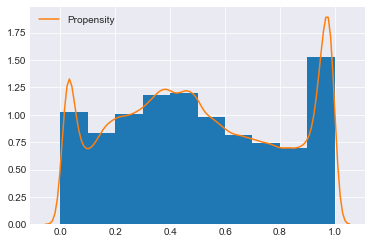

In [9]:
# plot the distrbution of the scored dataset
sns.set_style("darkgrid")
plt.hist(MAPD_score_df['Propensity'],normed=1)
sns.kdeplot(MAPD_score_df['Propensity'])

In [10]:
#Deciles for 2020 MAPD Population
MAPD_score_df['Decile'] = pd.qcut(MAPD_score_df['Propensity'].rank(method='first'),10,labels = np.arange(10,0,-1))
MAPD_score_df.groupby('Decile')['Propensity'].agg(['max','min','mean'])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,max,min,mean
Decile,,,
10,0.0960506,0.0000053,0.0430137
9,0.2145625,0.0960512,0.1597923
8,0.3129421,0.2145629,0.2645362
7,0.3965768,0.3129424,0.3557916
6,0.4791961,0.3965771,0.4382026
5,0.5748981,0.4791963,0.5248201
4,0.6956599,0.5748989,0.6336530
3,0.8322185,0.6956606,0.7622506
2,0.9512332,0.8322197,0.8994086


In [11]:
# append the decile and propensity back to the score datse
MAPD_score_df.reset_index(drop=False, inplace=True)
Active_members.reset_index(drop=False, inplace=True)
Active_members=pd.merge(Active_members,MAPD_score_df[['MEDICARE_NUMBER','Decile','Propensity']], how='left', on='MEDICARE_NUMBER')
Active_members.head()

,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,Call_counts,Decile,Propensity
0,1A00A14XD21,MEBN880Z,2018-01-01,9999-12-31,32,H5521,157,MA,NEW HAVEN,CT,NORTHEAST,CT_SHORELINE,1927-03-16,93,M,06514,09009,PPO,None,New Haven Community Medical Group ...,353696600,NE IND PPO,467454,40,None,None,Premier Senior Marketing,Health Insurance Assoc,"Casella, Nicola",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.2,0.00,6.0,4.0,0.0,0.0,4,0.6352233
1,1A00AD1NF33,MEBJ222P,2015-05-01,9999-12-31,64,H5521,082,MA,HENRICO,VA,MIDATLANTIC,VA_RICHMOND,1950-05-23,70,M,23059,51087,PPO,None,"Primary Health Group, Inc. ...",541717999,MA INDIVIDUAL PPO,467247,40,None,None,EXTEND INSURANCE SERVICES LLC,EXTEND INSURANCE SERVICES LLC,"Ennis, Kathleen",EmpGroupExchange,CAPITOL,None,None,Active,Issued,Individual,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,3.0,3.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.6,9.33,3.0,2.0,0.0,0.0,2,0.8403800
2,1A00AW0QH45,101047556200,2020-01-01,9999-12-31,8,H1609,027,MA,CHARLOTTE,FL,SOUTHEAST,FL_SOUTHWEST,1960-10-25,60,M,33983,12015,HMO,None,"Millennium Physician Group, LLC ...",262909414,None,None,None,None,None,"EHEALTHINSURANCE SERVICES, INC.","EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",Strategic,FLORIDA,None,None,Active,Issued,Individual,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.3,3273.12,36.0,9.0,0.0,0.0,8,0.2804003
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.00,0.0,0.0,0.0,9.0,2,0.9433690
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1

In [20]:
print(Active_members.MEDICARE_NUMBER.count())
Active_members.drop_duplicates(['MEDICARE_NUMBER'], keep='first').to_pickle('Active_members_07312020.pkl')

1584529


<font color='green'>**-----------------------------------------------Part 17:  Reset the prediction threshold from 0.5 to 0.77. -----------------------------------**</font>

In [12]:
# use default predict function, the threshold = 0.5
test=Active_members[model_columns]
test['Age']=test['Age'].astype(float)
test['IND_PCP']=test['IND_PCP'].map({'Yes':1,'No':0})
preds=pd.DataFrame(loaded_model.predict(test))
preds[0].value_counts(normalize=True)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.0    0.5250327
1.0    0.4749673
Name: 0, dtype: float64

In [13]:
#  set the threshold to 0.19, so we get cut of 22% of predicted veterans
y_pred = (loaded_model.predict_proba(test)[:,1] >= 0.81).astype(int) # set threshold as 0.19
print(pd.DataFrame(y_pred)[0].value_counts())
pd.DataFrame(y_pred)[0].value_counts(normalize=True)

0    1243428
1     341102
Name: 0, dtype: int64


0    0.7847299
1    0.2152701
Name: 0, dtype: float64

In [14]:
# check decile 3 to see if counts of predicted veterans vs predicted nonveterans
Active_members_all=pd.merge(Active_members,pd.DataFrame(y_pred), how='left', left_index=True, right_index=True).rename(columns={0:'Predicted_22pct'})
Active_members_all[Active_members_all['Decile']==3]['Predicted_22pct'].value_counts()

0    133565
1     24649
Name: Predicted_22pct, dtype: int64

In [15]:
# output the basic stats
print(Active_members_all[Active_members_all['Predicted_22pct']==1].CMS_State.value_counts(normalize=True))
print(Active_members_all[Active_members_all['Predicted_22pct']==1].Gender.value_counts(normalize=True))
print(Active_members_all[Active_members_all['Predicted_22pct']==1].Mbr_Mths.value_counts(normalize=True))
print(Active_members_all[Active_members_all['Predicted_22pct']==1].Age.value_counts(normalize=True))

IL    0.1143324
NC    0.0956195
NY    0.0922012
OH    0.0894776
NJ    0.0634737
GA    0.0524682
PA    0.0462354
CT    0.0400144
SC    0.0357254
TX    0.0346993
        ...    
AR    0.0012049
ID    0.0010847
OK    0.0009528
WY    0.0004984
SD    0.0002990
HI    0.0000059
MT    0.0000059
VT    0.0000029
PR    0.0000029
ND    0.0000029
Name: CMS_State, Length: 51, dtype: float64
M    0.5305334
F    0.4694666
Name: Gender, dtype: float64
20     0.3731259
8      0.0745290
32     0.0542096
44     0.0434973
68     0.0362120
19     0.0315507
56     0.0264320
17     0.0240075
13     0.0223980
14     0.0221166
         ...    
351    0.0000029
357    0.0000029
307    0.0000029
368    0.0000029
122    0.0000029
381    0.0000029
398    0.0000029
408    0.0000029
414    0.0000029
321    0.0000029
Name: Mbr_Mths, Length: 324, dtype: float64
67     0.0576755
66     0.0556119
73     0.0537342
71     0.0516392
72     0.0513934
70     0.0500955
75     0.0478964
68     0.0477389
69     0.0474617
74     

<font color='green'>**-----------------------------------------------Part 18:  Pull HEDIS 2019 - 2020. -----------------------------------**</font>

In [16]:
top_22_pct_veterans=Active_members_all[Active_members_all['Predicted_22pct']==1]['MEDICARE_NUMBER']
Active_members_top_22_veterans=Active_members[Active_members.MEDICARE_NUMBER.astype(str).isin(top_22_pct_veterans)]
Active_members_top_22_veterans.Age=Active_members_top_22_veterans.Age.astype(float)
Active_members_top_22_veterans.head()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,IND_PCP,PCP_Name_y,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,Call_counts,Decile,Propensity
3,1A00C26PG04,MEBPVQRT,2018-01-01,9999-12-31,32,H4523,021,MA,DENTON,TX,SOUTHCENTRAL,TX_DALLAS_FORT_WORTH,1952-07-17,68.0,M,76262,48121,HMO,None,Catalyst Health ...,737629500,SW INDIVIDUAL HMO,354054,40,None,None,CareFree,Healthcompare Insurance Services Inc,"Waldschmidt, Tony",CareFree,SOUTHCENTRAL,None,None,Active,Issued,Individual,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1,0.00,0.0,0.0,0.0,9.0,2,0.9182637
4,1A00CH1FY28,MEBRVB3K,2019-01-01,9999-12-31,20,H5521,033,MA,BROWARD,FL,SOUTHEAST,FL_SOUTH,1952-02-13,68.0,F,33065,12011,PPO,None,"Taylor, Donovan D ...",650697009,SE IND PPO,467101,40,None,None,None,None,None,Field,FLORIDA,None,None,Active,Issued,Individual,8.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,2.0,2.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.9,99.68,4.0,3.0,0.0,1.0,1,0.9647343
8,1A00ER4AF43,101184597100,2020-07-01,9999-12-31,2,H1608,039,MA,BOURBON,KS,NORTHCENTRAL,KS_MO_KANSAS_CITY,1932-10-04,88.0,F,66701,20011,PPO,None,"Barnidge, Margaret E ...",753002264,None,None,None,None,None,CareFree,Carefree Solutions USA,"Gelino, Daniel",CareFree,HEARTLAND,None,None,Active,Issued,Individual,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,No,NaN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,2,0.8827480
12,1A00JJ1KD11,MEBRY0DZ,2019-01-01,9999-12-31,20,H5521,140,MA,OCONEE,SC,SOUTHEAST,SC_UPSTATE,1936-04-20,84.0,F,29672,45073,PPO,None,Prisma Health-University Medical Group ...,571004971,SE IND PPO,466870,40,None,None,"Senior Marketing Specialists,",South Atlantic Management LLC,"Knight, Jeffrey",NDP,MIDSOUTH,None,None,Active,Issued,Individual,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,44.26,17.0,10.0,0.0,0.0,2,0.8629855
17,1A00NX4XD11,MEBQ252K,2019-01-01,9999-12-31,20,H5521,157,MA,FAIRFIELD,CT,NORTHEAST,CT_SHORELINE,1950-03-11,70.0,F,06897,09001,PPO,None,Soundview Medical Associates ...,061499825,NE IND PPO,467454,40,None,None,K F Agency Inc.,K F Agency Inc.,"Roberts, Kevin",NDP,NEWENGLAND,None,None,Active,Issued,Individual,0.0,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Yes,NaN,2.0,1.0,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.9,134.48,6.0,3.0,

In [17]:
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans[Active_members_top_22_veterans['Age']>=65]
Active_members_top_22_veterans_65_plus_list=Active_members_top_22_veterans_65_plus['MEDICARE_NUMBER']
Active_members_top_22_veterans_65_plus.CMS_State.value_counts()

IL    30095
NC    29700
NY    28849
GA    15745
OH    15597
PA    15246
NJ    14651
CT    14139
SC    13247
TX    10812
      ...  
NH      542
MD      392
OK      390
ID      366
DC      306
WY      135
SD      128
MT        1
VT        1
ND        1
Name: CMS_State, Length: 49, dtype: int64

In [18]:
# Active_members_top_22_veterans_65_plus[Active_members_top_22_veterans_65_plus.CMS_State=='OH'].describe(include=['O'])
Active_members_top_22_veterans_65_plus.describe(include=['O'])

,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,IND_PCP,PCP_Name_y
count,287627,287627,287627,287627,287627,287627,287627,287626,287627,287627,287627,287627,287627,287627,287363,287627,21223,264090,262860,223092,224192,223092,8,0.0,254033,248681,256485,280998,287627,2333,39237,287627,287627,287627,287627,0.0
unique,286892,286892,316,1,40,212,1,1041,49,6,211,12394,2,17462,1650,2,8,18809,18208,37,79,3,2,0.0,268,5034,27174,16,16,1,4,1,1,1,2,0.0
top,8KX2YG4WD10,101131093800,2019-01-01,9999-12-31,H5521,002,MA,COOK,IL,SOUTHEAST,GA_ATLANTA_METRO,1954-02-22,M,61032,17031,PPO,03,Allina Health ...,723583680,SE IND PPO,354646,40,Public_Labor,NaN,Senior Market Sales Inc.,"EHEALTHINSURANCE SERVICES, INC.","Hurley, Robert",NDP,MIDSOUTH,Y,1,Active,Issued,Individual,No,NaN
freq,16,16,128884,287627,167737,15498,287627,6751,30095,76659,13857,122,151352,1391,6751,212265,6137,4410,4410,58202,29667,223084,6,NaN,22175,12893,4827,160395,46012,2333,25755,287627,287627,287627,224022,NaN


In [19]:
# Active_members_top_22_veterans_65_plus[Active_members_top_22_veterans_65_plus.CMS_State=='OH'].describe(exclude=['O'])
Active_members_top_22_veterans_65_plus.describe(exclude=['O'])

,Mbr_Mths,Age,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,EMERG_VISITS,PRIMARY_CARE_VISITS,SPCLST_VISITS,IP_VISITS,PREVENTIVE_CARE_VISITS,EMERG_BENEFIT_PAID_AMT,PCP_BENEFIT_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,IP_BENEFIT_PAID_AMT,EMERG_MBR_PAID_AMT,PCP_MBR_PAID_AMT,SPCLST_MBR_PAID_AMT,IP_MBR_PAID_AMT,PAR_MED_CLAIM_COUNT,NONPAR_MED_CLAIM_COUNT,PAR_MED_VISITS,NONPAR_MED_VISITS,PAR_MED_BENEFIT_PAID_AMT,NONPAR_MED_BENEFIT_PAID_AMT,PAR_MED_MBR_PAID_AMT,NONPAR_MED_MBR_PAID_AMT,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,TOTAL_MED_COST,MBR_MED_DEDUCTIBLE_PAID_AMT,PAR_MED_MBR_DEDUCTIBLE_PAID_AMT,NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT,AMBULANCE_CLAIM_COUNT,AMBULANCE_EVENT_COUNT,BEHAVIORAL_HEALTH_CLAIM_COUNT,BEHAVIORAL_HEALTH_VISITS,Counts_Eligible,Counts_noncompliant,Adult BMI - Noncompliant,Breast Cancer Screening - Noncompliant,Colorectal Cancer - Noncompliant,Diabetes - Blood Sugar Controlled - Noncompliant,Diabetes - Eye - Noncompliant,Diabetes - Kidney - Noncompliant,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,Call_counts,Decile,Propensity
count,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0000000,287627.0,287627.0000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130074.0,NaN
mean,23.9710597,74.5296061,0.4293025,1.7794991,4.8261777,0.9575666,0.1713747,1.7116300,3.8026333,0.577112,0.1069162,96.9433208,187.3783058,678.6855090,982.7267493,6.7296656,10.2024150,106.1584372,60.3774300,7.2586336,1.1109284,5.6052213,1.0459414,2214.4854206,218.0319962,242.5897918,40.5302573,2432.5174168,283.1200492,2715.6374660,14.6192057,10.1107481,4.5084576,0.0707618,0.0665445,0.0746905,0.0844114,2.0142546,1.3456699,-0.4935907,-0.9886624,-0.2884569,-0.8015033,-0.8193459,-0.8593387,-0.9953

In [20]:
# Active_members_top_22_veterans_65_plus[Active_members_top_22_veterans_65_plus.CMS_State=='OH'].Decile.value_counts()
Active_members_top_22_veterans_65_plus.Decile.value_counts()

2     130074
1     126433
3      31120
4          0
5          0
6          0
7          0
8          0
9          0
10         0
Name: Decile, dtype: int64

In [21]:
Active_members_top_22_veterans_65_plus_list=Active_members_top_22_veterans_65_plus['MEDICARE_NUMBER']
print('22 pct member counts: ',len(Active_members_top_22_veterans_65_plus_list))
Active_members_top_22_veterans_65_plus.sort_values(['Propensity'], ascending=False,inplace=True)

22 pct member counts:  287627


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# load the HEDIS from 2019 -2020 file
HEDIS_PS_19_20_df=pd.read_csv('//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/HEDIS_PATIENTSAFETY_2019.csv')
print(HEDIS_PS_19_20_df.shape)
print(HEDIS_PS_19_20_df.info())
HEDIS_PS_19_20_df.head()

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5327174, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5327174 entries, 0 to 5327173
Data columns (total 10 columns):
MEASURE_ID          int64
MEASURE_NM          object
COMPLIANCE_DT       object
COMPLIANCE_YEAR     float64
COMPLIANCE_MONTH    float64
FORECAST_WEIGHT     float64
DOMAIN              object
HICN_NBR            object
NUMERATOR           int64
DENOMINATOR         float64
dtypes: float64(4), int64(2), object(4)
memory usage: 406.4+ MB
None


,MEASURE_ID,MEASURE_NM,COMPLIANCE_DT,COMPLIANCE_YEAR,COMPLIANCE_MONTH,FORECAST_WEIGHT,DOMAIN,HICN_NBR,NUMERATOR,DENOMINATOR
0,102401,Colorectal Cancer,01JAN2010,2010.0,1.0,1.0,HEDIS,1VM1FV3XK26,1,1.0
1,102401,Colorectal Cancer,01JAN2010,2010.0,1.0,1.0,HEDIS,1VR3YV5WQ04,1,1.0
2,102401,Colorectal Cancer,01JAN2010,2010.0,1.0,1.0,HEDIS,2N52GV7GY03,1,1.0
3,102401,Colorectal Cancer,01JAN2010,2010.0,1.0,1.0,HEDIS,316583598A,1,1.0
4,102401,Colorectal Cancer,01JAN2010,2010.0,1.0,1.0,HEDIS,3J30YJ1GK39,1,1.0


In [23]:
# only look at the 13 reported HEDIS and Patient Safety measures
drop_list=['Controlling High Blood Pressure','SNP - Functional Status Assessment',
'SNP - Medication','SNP - Pain Screening']
HEDIS_PS_19_20_df=HEDIS_PS_19_20_df[~HEDIS_PS_19_20_df.MEASURE_NM.isin(drop_list)]
HEDIS_PS_19_20_df.MEASURE_NM.value_counts()

Colorectal Cancer                           794323
Adult BMI                                   782838
Statin Adherence                            762867
ACEI/ARB Adherence                          696392
Medication Reconciliation Post Discharge    322916
Breast Cancer Screening                     314982
Diabetes - Kidney                           307635
Diabetes - Eye                              307632
Diabetes - Blood Sugar Controlled           307631
Diabetes Adherence                          242816
Statin use in Diabetes                      223033
Medication Therapy Management               132492
Statin Therapy for Patients with CD          66896
Rheumatoid Arthritis                         18293
Osteo Screening                               5206
Name: MEASURE_NM, dtype: int64

In [24]:
# create compliant indicator for each HEDIS and PatientSafety Measure
# Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus[Active_members_top_22_veterans_65_plus.CMS_State=='OH']
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Adult BMI'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Adult BMI - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Breast Cancer Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Breast Cancer Screening - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Colorectal Cancer'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Colorectal Cancer - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes - Blood Sugar Controlled'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Blood Sugar Controlled - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes - Eye'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Eye - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes - Kidney'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Kidney - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Osteo Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Osteo Screening - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Rheumatoid Arthritis'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Rheumatoid Arthritis - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Statin Therapy for Patients with CD'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Therapy for Patients with CD - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Medication Reconciliation Post Discharge'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Reconciliation Post Discharge'})    
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Medication Therapy Management'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Therapy Management'})  
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='ACEI/ARB Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'ACEI/ARB Adherence - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes Adherence - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Statin Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Adherence - Compliant'})
Active_members_top_22_veterans_65_plus=Active_members_top_22_veterans_65_plus.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Statin use in Diabetes'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin use in Diabetes - Compliant'})
print("Number of unique members: ",Active_members_top_22_veterans_65_plus.MEDICARE_NUMBER.nunique())
Active_members_top_22_veterans_65_plus.head()

Number of unique members:  286892


,MEDICARE_NUMBER,Member_ID,Eff_Date,Term_Date,Mbr_Mths,Contract_Number,PBP,Product,CMS_County,CMS_State,NEW_REGION,MA_Territory,DOB,Age,Gender,Zip,FIPS,Plan_Type,dual_Status,PCP_Name_x,PCP_Tax_ID,GroupName,GroupNumber,GroupSegment,GroupSegmentName,TRR_Parent_Name,TOH_Name,Recruiter_Name,Writing_Agent_Name,Sales_Channel,New_Market,SNP,LIS_Flag,Enroll_Status,Issued_Status,Group_Status,EMERG_TRANSACTIONS,PCP_TRANSACTIONS,SPCLST_TRANSACTIONS,IP_TRANSACTIONS,...,Osteo Screening - Noncompliant,Rheumatoid Arthritis - Noncompliant,Statin Therapy for Patients with CD - Noncompliant,Medication Reconciliation Post Discharge - Noncompliant,Medication Therapy Management - Noncompliant,ACEI/ARB Adherence - Noncompliant,Diabetes Adherence - Noncompliant,Statin Adherence - Noncompliant,Statin use in Diabetes - Noncompliant,Ind_PTSD_Related_Disorders,Ind_Addictive_diagnosis,High_Need_Group,Ind_Mental_Disorder,HOSPICE_IND,DISABILITY_IND,ESRD_IND,OUT_OF_AREA_FLAG,Distance_From_VA,RX_MBR_PAID_AMOUNT,RX_CLAIM_COUNT,DISTINCT_GPI,GRV_COUNTS,Call_counts,Decile,Propensity,Adult BMI - Compliant,Breast Cancer Screening - Compliant,Colorectal Cancer - Compliant,Diabetes - Blood Sugar Controlled - Compliant,Diabetes - Eye - Compliant,Diabetes - Kidney - Compliant,Osteo Screening - Compliant,Rheumatoid Arthritis - Compliant,Statin Therapy for Patients with CD - Compliant,Medication Reconciliation Post Discharge,Medication Therapy Management,ACEI/ARB Adherence - Compliant,Diabetes Adherence - Compliant,Statin Adherence - Compliant,Statin use in Diabetes - Compliant
0,8WK7HC9FG42,MEBSCQPM,2019-02-01,9999-12-31,19,H3931,130,MA,MARICOPA,AZ,NORTHCENTRAL,AZ_PHOENIX,1948-06-01,72.0,F,91356,04013,HMO,None,4C Medical Group PLC ...,452402948,WC INDIVIDUAL HMO,354163,40,None,None,Senior Market Sales Inc.,"Health Plan One, LLC","Roman, Edgar",Strategic,ARIZONA,None,None,Active,Issued,Individual,0.0,0.0,0.0,0.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,242.3,0.00,0.0,0.0,0.0,2.0,1,0.9996947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,8M08K91MW65,MEBQT47B,2019-01-01,9999-12-31,20,H5521,159,MA,ESSEX,MA,NORTHEAST,MA_EASTERN,1948-06-30,72.0,M,33884,25009,PPO,None,"Cecchetti, Carlo ...",042929385,NE IND PPO,467454,40,None,None,"Aon Hewitt Health Market Insurance Solutions, ...","Aon Hewitt Health Market Insurance Solutions, ...","Fee, Sandra",EmpGroupExchange,NEWENGLAND,None,None,Active,Issued,Individual,5.0,1.0,4.0,0.0,...,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1098.5,11.62,7.0,4.0,0.0,14.0,1,0.9996012,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN
2,6DY3W92CA88,MEBQX5QV,2019-01-01,9999-12-31,20,H5521,099,MA,ALLEN,IN,NORTHCENTRAL,IN_NORTHEAST,1948-08-28,72.0,M,32754,18003,PPO,None,Parkview Care Partners LLC ...,570562430,NC IND PPO,467248,40,None,None,Senior Market Sales Inc.,"Unisource, LLC","Bryk, Vicki",NDP,GREATLAKES,None,None,Active,Issued,Individual,6.0,4.0,16.0,8.0,...,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,721.9,96.66,3.0,3.0,0.0,14.0,1,0.9994506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,8DJ5C03VQ40,MEBSM07R,2019-04-01,9999-12-31,17,H3312,064,MA,SUFFOLK,NY,NORTHEAST,NY_LONG_ISLAND,1949-02-15,71.0,M,22630,36103,HMO,None,Northwell ...,650301410,NE INDIVIDUAL HMO,354055,40,None,None,TZ Insurance Solutions LLC,TZ Insurance Solutions LLC,"Aby, Laetitia",Strategic,NYNJ,None,None,Active,Issued,Individual,8.0,5.0,7.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,216.7,0.00,0.0,0.0,0.0,0.0,1,0.9994310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,7DW0C95CD08,MEBRF0CW,2018-12-01,9999-12-31,21,H5521,091,MA,PICKENS,GA,SOUTHEAST,GA_ATLANTA_METRO,1947-04-12,73.0,M,28645,13227,PPO,None,Piedmont IPA ...,986673670,GA IND PPO,354440,40,None,None,"Amerilife Agencies,",SELECTQUOTE INSURANCE SERVICES,"Grant, Robert",NDP,GEORGIAGULFSTATES,None,None,Active,Issued,Individual

#### all 22 pct HEDIS measures from 2019 to 2020

In [25]:
Active_members_top_22_veterans_65_plus_unique=Active_members_top_22_veterans_65_plus.groupby('MEDICARE_NUMBER')[['Adult BMI - Compliant','Breast Cancer Screening - Compliant',
                'Colorectal Cancer - Compliant','Diabetes - Blood Sugar Controlled - Compliant','Diabetes - Eye - Compliant',
                'Diabetes - Kidney - Compliant','Osteo Screening - Compliant','Rheumatoid Arthritis - Compliant',
                'Statin Therapy for Patients with CD - Compliant','Medication Reconciliation Post Discharge',
                'Medication Therapy Management','ACEI/ARB Adherence - Compliant','Diabetes Adherence - Compliant',
                'Statin Adherence - Compliant','Statin use in Diabetes - Compliant']].max()
Active_members_top_22_veterans_65_plus_unique

,Adult BMI - Compliant,Breast Cancer Screening - Compliant,Colorectal Cancer - Compliant,Diabetes - Blood Sugar Controlled - Compliant,Diabetes - Eye - Compliant,Diabetes - Kidney - Compliant,Osteo Screening - Compliant,Rheumatoid Arthritis - Compliant,Statin Therapy for Patients with CD - Compliant,Medication Reconciliation Post Discharge,Medication Therapy Management,ACEI/ARB Adherence - Compliant,Diabetes Adherence - Compliant,Statin Adherence - Compliant,Statin use in Diabetes - Compliant
MEDICARE_NUMBER,,,,,,,,,,,,,,,
1A00C26PG04,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00CH1FY28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00ER4AF43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00JJ1KD11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1A00NX4XD11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00P98RX17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00QR2PG04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1A00RF6RY47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00TK0AF03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [26]:
print(Active_members_top_22_veterans_65_plus_unique['Adult BMI - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Breast Cancer Screening - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Colorectal Cancer - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Diabetes - Blood Sugar Controlled - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Diabetes - Eye - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Diabetes - Kidney - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Osteo Screening - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Rheumatoid Arthritis - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Statin Therapy for Patients with CD - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Medication Reconciliation Post Discharge'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Medication Therapy Management'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['ACEI/ARB Adherence - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Diabetes Adherence - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Statin Adherence - Compliant'].value_counts())
print(Active_members_top_22_veterans_65_plus_unique['Statin use in Diabetes - Compliant'].value_counts())

1.0    24687
0.0    10311
Name: Adult BMI - Compliant, dtype: int64
1.0    2280
0.0    1718
Name: Breast Cancer Screening - Compliant, dtype: int64
1.0    24290
0.0    18497
Name: Colorectal Cancer - Compliant, dtype: int64
1.0    12896
0.0    12409
Name: Diabetes - Blood Sugar Controlled - Compliant, dtype: int64
1.0    16051
0.0     9254
Name: Diabetes - Eye - Compliant, dtype: int64
1.0    23365
0.0     1940
Name: Diabetes - Kidney - Compliant, dtype: int64
0.0    149
1.0    148
Name: Osteo Screening - Compliant, dtype: int64
1.0    1217
0.0     385
Name: Rheumatoid Arthritis - Compliant, dtype: int64
1.0    2980
0.0    1242
Name: Statin Therapy for Patients with CD - Compliant, dtype: int64
1.0    16268
0.0     4253
Name: Medication Reconciliation Post Discharge, dtype: int64
1.0    6267
0.0    1661
Name: Medication Therapy Management, dtype: int64
1.0    76869
0.0    12705
Name: ACEI/ARB Adherence - Compliant, dtype: int64
1.0    26435
0.0     4673
Name: Diabetes Adherence - Compl

<font color='green'>**-----------------------------------------------Part 19:  MAPD IVL 2019 - 2020. -----------------------------------**</font>

In [41]:
# load the HEDIS from 2019 -2020 file
HEDIS_PS_19_20_df=pd.read_csv('//mbip/medicarepBI/Projects/COE/Veteran_Analytics/raw_data/HEDIS_PATIENTSAFETY.csv')
print(HEDIS_PS_19_20_df.shape)
print(HEDIS_PS_19_20_df.info())
HEDIS_PS_19_20_df.head()

(6519830, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6519830 entries, 0 to 6519829
Data columns (total 7 columns):
MEASURE_ID         int64
MEASURE_NM         object
FORECAST_WEIGHT    float64
DOMAIN             object
HICN_NBR           object
NUMERATOR          int64
DENOMINATOR        float64
dtypes: float64(2), int64(2), object(3)
memory usage: 348.2+ MB
None


,MEASURE_ID,MEASURE_NM,FORECAST_WEIGHT,DOMAIN,HICN_NBR,NUMERATOR,DENOMINATOR
0,104201,Osteo Screening,1.0,HEDIS,1A07TC9KY50,0,1.0
1,104201,Osteo Screening,1.0,HEDIS,1A21QN6DF15,0,1.0
2,104201,Osteo Screening,1.0,HEDIS,1A41DK3AA93,0,1.0
3,104201,Osteo Screening,1.0,HEDIS,1A43T79JY11,1,1.0
4,104201,Osteo Screening,1.0,HEDIS,1A51EW1TE17,0,1.0


In [42]:
# only look at the 13 reported HEDIS and Patient Safety measures
drop_list=['Controlling High Blood Pressure','SNP - Functional Status Assessment',
'SNP - Medication','SNP - Pain Screening']
HEDIS_PS_19_20_df=HEDIS_PS_19_20_df[~HEDIS_PS_19_20_df.MEASURE_NM.isin(drop_list)]
HEDIS_PS_19_20_df.MEASURE_NM.value_counts()

Colorectal Cancer                           1042003
Adult BMI                                    987967
Statin Adherence                             682304
ACEI/ARB Adherence                           625442
Breast Cancer Screening                      382474
Diabetes - Eye                               337986
Diabetes - Kidney                            337986
Diabetes - Blood Sugar Controlled            337986
Diabetes Adherence                           231801
Statin use in Diabetes                       199253
Medication Reconciliation Post Discharge     112742
Medication Therapy Management                 95095
Statin Therapy for Patients with CD           69422
Rheumatoid Arthritis                          11101
Osteo Screening                                5739
Name: MEASURE_NM, dtype: int64

In [43]:
# create compliant indicator for each HEDIS and PatientSafety Measure
HEDIS_PS_df=Active_members[['MEDICARE_NUMBER']].merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Adult BMI'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Adult BMI - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Breast Cancer Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Breast Cancer Screening - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Colorectal Cancer'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Colorectal Cancer - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes - Blood Sugar Controlled'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Blood Sugar Controlled - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes - Eye'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Eye - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes - Kidney'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes - Kidney - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Osteo Screening'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Osteo Screening - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Rheumatoid Arthritis'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Rheumatoid Arthritis - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Statin Therapy for Patients with CD'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Therapy for Patients with CD - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Medication Reconciliation Post Discharge'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Reconciliation Post Discharge'})    
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Medication Therapy Management'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Medication Therapy Management'})  
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='ACEI/ARB Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'ACEI/ARB Adherence - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Diabetes Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Diabetes Adherence - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Statin Adherence'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin Adherence - Compliant'})
HEDIS_PS_df=HEDIS_PS_df.merge(HEDIS_PS_19_20_df[HEDIS_PS_19_20_df.MEASURE_NM=='Statin use in Diabetes'][['HICN_NBR','NUMERATOR']],
            how='left', left_on='MEDICARE_NUMBER',right_on='HICN_NBR').drop(['HICN_NBR'],axis=1)\
            .rename(columns={'NUMERATOR':'Statin use in Diabetes - Compliant'})
print("Number of unique members: ",HEDIS_PS_df.MEDICARE_NUMBER.nunique())
HEDIS_PS_df.head()

Number of unique members:  1577194


,MEDICARE_NUMBER,Adult BMI - Compliant,Breast Cancer Screening - Compliant,Colorectal Cancer - Compliant,Diabetes - Blood Sugar Controlled - Compliant,Diabetes - Eye - Compliant,Diabetes - Kidney - Compliant,Osteo Screening - Compliant,Rheumatoid Arthritis - Compliant,Statin Therapy for Patients with CD - Compliant,Medication Reconciliation Post Discharge,Medication Therapy Management,ACEI/ARB Adherence - Compliant,Diabetes Adherence - Compliant,Statin Adherence - Compliant,Statin use in Diabetes - Compliant
0,1A00A14XD21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,1A00AD1NF33,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,1A00AW0QH45,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1A00C26PG04,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1A00CH1FY28,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
HEDIS_PS_df_unique=HEDIS_PS_df.groupby('MEDICARE_NUMBER')[['Adult BMI - Compliant','Breast Cancer Screening - Compliant',
                'Colorectal Cancer - Compliant','Diabetes - Blood Sugar Controlled - Compliant','Diabetes - Eye - Compliant',
                'Diabetes - Kidney - Compliant','Osteo Screening - Compliant','Rheumatoid Arthritis - Compliant',
                'Statin Therapy for Patients with CD - Compliant','Medication Reconciliation Post Discharge',
                'Medication Therapy Management','ACEI/ARB Adherence - Compliant','Diabetes Adherence - Compliant',
                'Statin Adherence - Compliant','Statin use in Diabetes - Compliant']].max()
HEDIS_PS_df_unique

,Adult BMI - Compliant,Breast Cancer Screening - Compliant,Colorectal Cancer - Compliant,Diabetes - Blood Sugar Controlled - Compliant,Diabetes - Eye - Compliant,Diabetes - Kidney - Compliant,Osteo Screening - Compliant,Rheumatoid Arthritis - Compliant,Statin Therapy for Patients with CD - Compliant,Medication Reconciliation Post Discharge,Medication Therapy Management,ACEI/ARB Adherence - Compliant,Diabetes Adherence - Compliant,Statin Adherence - Compliant,Statin use in Diabetes - Compliant
MEDICARE_NUMBER,,,,,,,,,,,,,,,
1A00A14XD21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1A00AD1NF33,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1A00AW0QH45,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00C26PG04,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00CH1FY28,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00CR2PG14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1A00DH8FA38,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
1A00E82DH35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1A00ER4AF43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
print(HEDIS_PS_df_unique['Adult BMI - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Breast Cancer Screening - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Colorectal Cancer - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Diabetes - Blood Sugar Controlled - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Diabetes - Eye - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Diabetes - Kidney - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Osteo Screening - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Rheumatoid Arthritis - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Statin Therapy for Patients with CD - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Medication Reconciliation Post Discharge'].value_counts())
print(HEDIS_PS_df_unique['Medication Therapy Management'].value_counts())
print(HEDIS_PS_df_unique['ACEI/ARB Adherence - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Diabetes Adherence - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Statin Adherence - Compliant'].value_counts())
print(HEDIS_PS_df_unique['Statin use in Diabetes - Compliant'].value_counts())

1.0    409471
0.0    170827
Name: Adult BMI - Compliant, dtype: int64
1.0    148755
0.0     77161
Name: Breast Cancer Screening - Compliant, dtype: int64
1.0    331554
0.0    274254
Name: Colorectal Cancer - Compliant, dtype: int64
0.0    145171
1.0     63814
Name: Diabetes - Blood Sugar Controlled - Compliant, dtype: int64
0.0    120829
1.0     88156
Name: Diabetes - Eye - Compliant, dtype: int64
1.0    172971
0.0     36014
Name: Diabetes - Kidney - Compliant, dtype: int64
0.0    3371
1.0    1281
Name: Osteo Screening - Compliant, dtype: int64
1.0    6619
0.0    2185
Name: Rheumatoid Arthritis - Compliant, dtype: int64
1.0    43133
0.0    12366
Name: Statin Therapy for Patients with CD - Compliant, dtype: int64
1.0    47839
0.0     6163
Name: Medication Reconciliation Post Discharge, dtype: int64
1.0    38687
0.0    32013
Name: Medication Therapy Management, dtype: int64
1.0    477859
0.0     24733
Name: ACEI/ARB Adherence - Compliant, dtype: int64
1.0    176773
0.0     10784
Name: Di